# &AElig;co
***View module***
<br/><br/>

✈️♻️

This code is part of the Master's Thesis "Streamlined Life Cycle Assessment Method for Aircraft Eco-Design", by Giácomo Parolin.

``Please enter the following information:``

In [4]:
results_path = '.\\results\\A320_outputs_10k'  # LCA results file path

# Initial Definitions

Loading packages and defining classes.

In [2]:
from LCA import *

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rc
import warnings
import squarify
import xarray as xr
import dask.dataframe as dd
import dask.array as da
import bottleneck

In [73]:
class LCIA():
    """Represent LCIA results."""
    
    def __init__(self, LCI=None, CF=None, CTV=None, MP=None, EP=None):
        """Initializes the LCIA object with a LCI and CF."""
        
        self.LCI = LCI
        self.CF = CF
        self.CTV = CTV
        self.MP = MP
        self.EP = EP
        self.phases = {'Development': ['Office','Infrastructure','Capital','Prototypes','Certification'],
                       'Manufacturing': ['Materials','Factory','Logistics','Sustaining'],
                       'Operation': ['LTO','CCD','Maintenance','Airport','Fuel'],
                       'End-of-Life': ['Recycling','Landfill','Incineration']
                      }
        
    def __repr__(self):
        return f"LCIA results of the {self.MP.attrs['Name']}"
    
    def __getitem__(self, item):
        return xr.concat((self.MP[item], self.EP[item]), dim='Pathway')
    
    @classmethod
    def build(cls, LCI, CF):
        """Assesses midpoint and endpoint impacts. Returns the LCI.MP and LCI.EP datasets."""
        
        MP = (LCI.data * CF.MP.array).sum('Substances')
        MP.attrs = LCI.data.attrs
        MP = MP.rename({'variable':'Categories'})
        
        EP = (MP * CF.EP.array).sum('Categories')
        EP.attrs = MP.attrs
        EP = EP.rename({'variable':'AOP'})

        return cls(LCI=LCI, CF=CF, MP=MP, EP=EP)
    
    def SS(self, by="phase"):
        """Returns the LCA Single Score as a xr.Dataset."""
        
        cf = np.array([1.35e-2*400,9.17e-4*400,2.45e-2*200])
        ss = xr.DataArray(cf, coords={'AOP':self.EP.AOP.data}, dims='AOP')
        
        return (self.groupby(by, "EP") * ss).sum('AOP')
                         
    def mean(self, pathway="MP", by="subphase"):
        """Returns a xr.Dataset with the mean result for the chosen pathway and groupby.
        
        By can be either "sum", which returns a dataset summed over all phases;
                         "phases", which returns a dataset grouped by phases; or
                         "subphases", which returns a dataset grouped by subphases. 
        """
        
        return self.groupby(by=by, pathway=pathway).mean('i')

    def groupby(self, by="phase", pathway="MP"):
        """Returns xr.Dataset of desired pathway with aggregated life cycle phases.
        
        By can be either "sum", which returns a dataset summed over all phases;
                         "phases", which returns a dataset grouped by phases; or
                         "subphases", which returns a dataset grouped by subphases. 
        """
        
        if pathway == "MP":
            data = self.MP
        elif pathway == "EP":
            data = self.EP
        
        if by == "phase":
            ds = xr.Dataset()
            for phase in self.phases:
                ds[phase] = data[self.phases[phase]].to_array().sum('variable')
            return ds
        elif by == "sum":
            return data.to_array('Phases').sum('Phases')
        else:
            return data
            
    def build_CTV(self, parameterset):
        """Calculates the CTV of the parameterset for MP and EP."""
        
        if self.CTV == None:
            param_arr = parameterset.data.to_array('Parameters').loc[{'Parameters':[*parameterset.parameters]}]
            self.MP_array = self.MP.to_array().sum('variable').to_dataset('Categories')
            self.EP_array = self.EP.to_array().sum('variable').to_dataset('AOP')
            self.array = xr.merge([self.MP_array,self.EP_array])
            
            param_arr_nochunk = param_arr.loc[{'i':slice(999)}].chunk({'i':-1})
            array_nochunk = self.array.loc[{'i':slice(999)}].chunk({'i':-1})
            
            corr = spearman_correlation(param_arr_nochunk,array_nochunk,dim='i')
            corr_sq = corr ** 2
            corr_sum = corr_sq.sum(dim='Parameters')
            ctv = corr_sq / corr_sum
            self.CTV = ctv.fillna(0)*100
            
        return self.CTV
    
    def save(self, path, LCI=True):
        """Saves LCIA object to a NetCDF file."""
        
        
        self.MP.to_netcdf(path, group='MP', mode='w')
        self.EP.to_netcdf(path, group='EP', mode='a')
        
        if LCI:
            self.LCI.data.reset_index("Substances").to_netcdf(path, group='LCI', mode='a')
        
        if self.CTV != None:
            self.CTV.to_netcdf(path, group='CTV', mode='a')
        
        return print(f"LCIA saved at {path}")
    
    def to_excel(self, path, LCI=False):
        """Saves LCIA object to a .xlsx file."""
        
        if path[-5:] == '.xlsx':
            path = path
        else:
            path = path + '.xlsx'
        
        with pd.ExcelWriter(path) as writer:
            self.MP.to_dataframe().to_excel(writer, sheet_name='MP')
            self.EP.to_dataframe().to_excel(writer, sheet_name='EP')
            
            if self.CTV != None:
                self.CTV.to_dataframe().to_excel(writer, sheet_name='CTV')
                
            if LCI:
                self.LCI.data.reset_index("Substances").to_netcdf(path, group='LCI', mode='a')
        
        return print(f"LCIA saved at {path}")
    
    @classmethod
    def load(cls, path, chunks={}, CTV=False, LCI=False):
        """Loads NetCDF file from path.
        
        chunks: specify the chunks to pass the xr.open_dataset function.
        CTV: boolean that specifies if a CTV group if present on the NetCDF file.
        """
        
        ctv = None
        lci = None
        
        with xr.open_dataset(path, chunks=chunks, group='MP') as mp, \
             xr.open_dataset(path, chunks=chunks, group='EP') as ep:
            
            if LCI:
                with xr.open_dataset(path, chunks=chunks, group='LCI') as ds:
                    lci = ds.set_index({"Substances":["name","compartment","subcompartment"]})
        
            if CTV:
                with xr.open_dataset(path, chunks=chunks, group='CTV') as ds:
                    ctv = ds
            
            return cls(MP=mp, EP=ep, LCI=lci, CTV=ctv)
        
    
    def dist(self, pathway='MP', save=False):
        """Plots the distribution of iterations for the pathway's categories."""
        
        fig = plt.figure(figsize=(13, 19), dpi=150)
        sns.despine(left=True)
        sns.set(style="ticks", palette='GnBu', color_codes=True)

        outer = gridspec.GridSpec(6, 3, wspace=0.2, hspace=0.35)
        
        if pathway == 'MP':
            da = self.MP.to_array().sum('variable')
            lst = self.MP['Categories'].data
            name = self.MP.attrs['Name'] + "_MP_"
            finder = 'Categories'
            
        elif pathway == 'EP':
            da = self.EP.to_array().sum('variable')
            lst = self.EP['AOP'].data
            name = self.EP.attrs['Name'] + "_EP_"
            finder = 'AOP'
        
        i = 0
        for cat in lst:

            inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], 
                                                     wspace=0.1, hspace=0.1, height_ratios=(.15, .85))
            
            data = da.loc[{finder:cat}]
            
            ax = plt.Subplot(fig, inner[0])
            ax.set_xticks([])
            sns.boxplot(data, ax=ax, color='seagreen', notch=True)
            ax.set_xlabel('')
            ax.set_yticks([])
            fig.add_subplot(ax)
            i += 1

            ax = plt.Subplot(fig, inner[1])
            ax.axvline(data.mean(), 0, 1, color='darkgreen', ls= '--')
            sns.distplot(data, kde=False, color='forestgreen', ax=ax)
            ax.set_yticks([])
            ax.set_xlabel(cat, fontsize=12)
            ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
            ax.set_xticks([data.min(), data.mean(), data.max()])
            fig.add_subplot(ax)
        
        if save:
            fig.savefig('.\\results\\' + name + 'dist.pdf', bbox_inches='tight', papertype='A3')    
        
        plt.show()
        
    
    def bar(self, pathway='MP', subphase=True, save=False):
        """Plots the percentual contribution of each life cycle phase to the pathway's categories."""
        
        if pathway == 'MP':
            lst = self.MP['Categories'].data
            name = self.MP.attrs['Name'] + "_MP_"
            finder = 'Categories'
            xlabel = "Midpoint categories"
            ylabel = "Percent of midpoint impact'"
            xticks = 18
            ymin = -20
            
        elif pathway == 'EP':
            lst = self.EP['AOP'].data
            name = self.EP.attrs['Name'] + "_EP_"
            finder = 'AOP'
            xlabel = "Endpoint Areas of Protection"
            ylabel = "Percent of endpoint impact'"
            xticks = 3
            ymin = -5
            
        
        if subphase:
            data = self.mean(pathway, by="subphase")
            name = name + "subphase_"
        else:
            data = self.mean(pathway, by="phase")
            name = name + "phase_"
        
        ds = xr.Dataset()
        for cat in lst:
            num = data.loc[{finder:cat}]
            den = abs(num.to_array()).sum()
            pct = num / den * 100
            pct = pct.to_array('Phases').drop(finder)
            ds[cat] = pct
        df = ds.to_dataframe().T
                
        sns.set(style="white", palette='deep', color_codes=False)
        ax = df.plot.bar(stacked= True, figsize=(18,8), width=0.8)
        fig = ax.get_figure();
        fig.set_dpi(150)
        ax.axhline(lw=1, color='k')
        plt.title('')
        plt.ylabel(ylabel, fontsize=13)
        plt.xlabel(xlabel, fontsize=13)
        plt.xticks(ticks=np.arange(0,xticks), rotation=0, horizontalalignment='center')
        plt.yticks(ticks=[ymin,0,20,40,60,80,100], fontsize=13)
        plt.ylim(top=100)
        plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0.2, edgecolor='w', fontsize=11)
        
        if save:
            fig.savefig('.\\results\\' + name + 'bar.pdf', bbox_inches='tight', papertype='A3')
            
        plt.show()
        
    def square(self, save=False):
        """Plots the CTV results for each category."""
        
        name = self.MP.attrs['Name']
        np.set_printoptions(precision=2)
        with PdfPages('.\\results\\' + name + '_CTV.pdf') as pdf:
            for cat in self.CTV:
                da = self.CTV[cat].compute()
                da = da.sortby(da, ascending=False)

                data = da.data[da.data>0]
                labels  = [f"{da[i].coords['Parameters'].data}\n{data[i].round(2)}%" for i in range(6)]
                colors = [plt.cm.Spectral(i/float(len(data))) for i in range(len(data))]

                plt.figure(figsize=(13,7), dpi=150)
                squarify.plot(data, label=labels)
                plt.title('CTV: ' + cat)
                plt.axis('off')

                if save:
                    pdf.savefig(bbox_inches='tight', papertype='A4')

                plt.show()

In [3]:
color_map = ('lightcoral','red','indianred','tomato','firebrick',\
            'darkkhaki', 'yellow', 'gold','darkorange',\
            'green', 'seagreen', 'darkturquoise','teal','lightseagreen',\
            'orchid', 'darkviolet','purple')

palette = sns.cubehelix_palette(18, start=.3, rot=-0.9, gamma=.9, hue=1, dark=0.05, light=0.9)

Loading saved values from the `A320_calc.ipynb` module.

In [5]:
aeco = LCIA.load(results_path, chunks={}, LCI=False, CTV=True)

# Midpoint Results

The distributions of the results, considering all the iterations, are plotted for each impact category using the `LCIA.dist()` method.

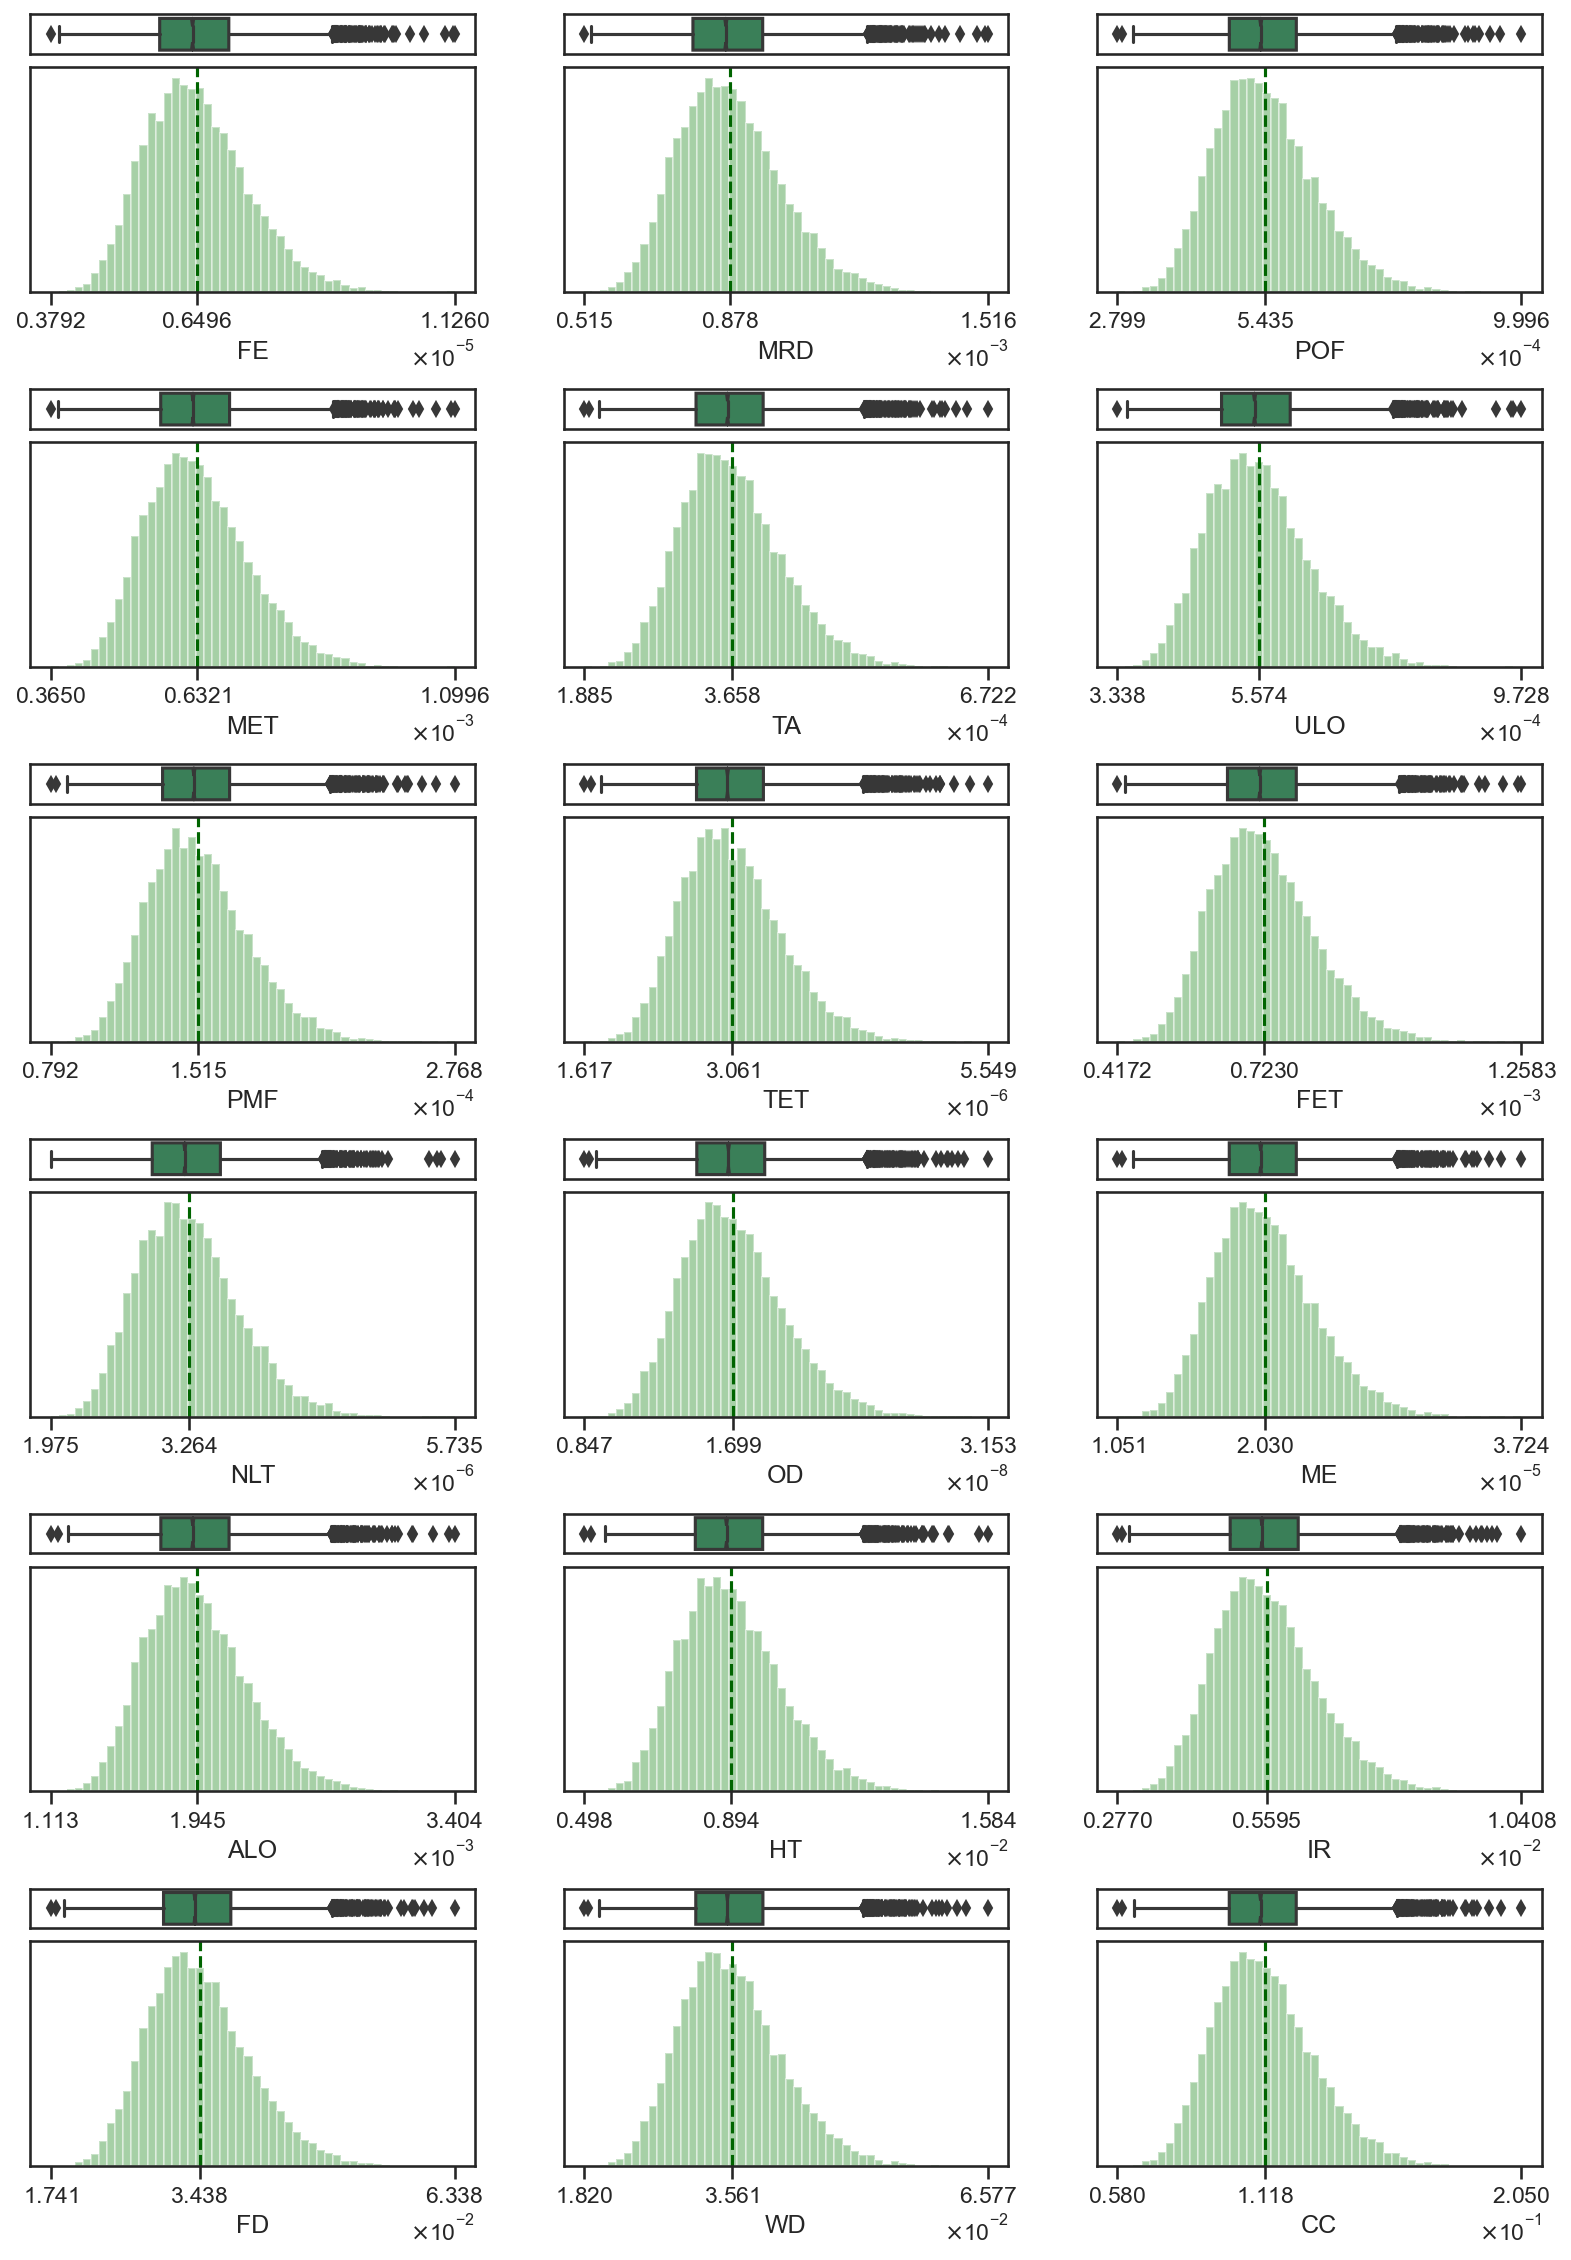

In [5]:
aeco.dist('MP', save=False)

Mean midpoint results are shown below.

In [6]:
aeco.mean('MP', by='sum').compute()

<xarray.DataArray 'stack-f797cef3844650da1df86f5bbd80c42d' (Categories: 18)>
array([6.49618570e-06, 8.78206071e-04, 5.43461344e-04, 6.32100838e-04,
       3.65841217e-04, 5.57444668e-04, 1.51505036e-04, 3.06111706e-06,
       7.22993960e-04, 3.26427901e-06, 1.69948970e-08, 2.02974063e-05,
       1.94473855e-03, 8.93749102e-03, 5.59481586e-03, 3.43766042e-02,
       3.56096607e-02, 1.11805810e-01])
Coordinates:
  * Categories  (Categories) object 'FE' 'MRD' 'POF' 'MET' ... 'FD' 'WD' 'CC'

Next, we calculate mean midpoint impacts per life cycle phase using the `LCIA.bar()` method.

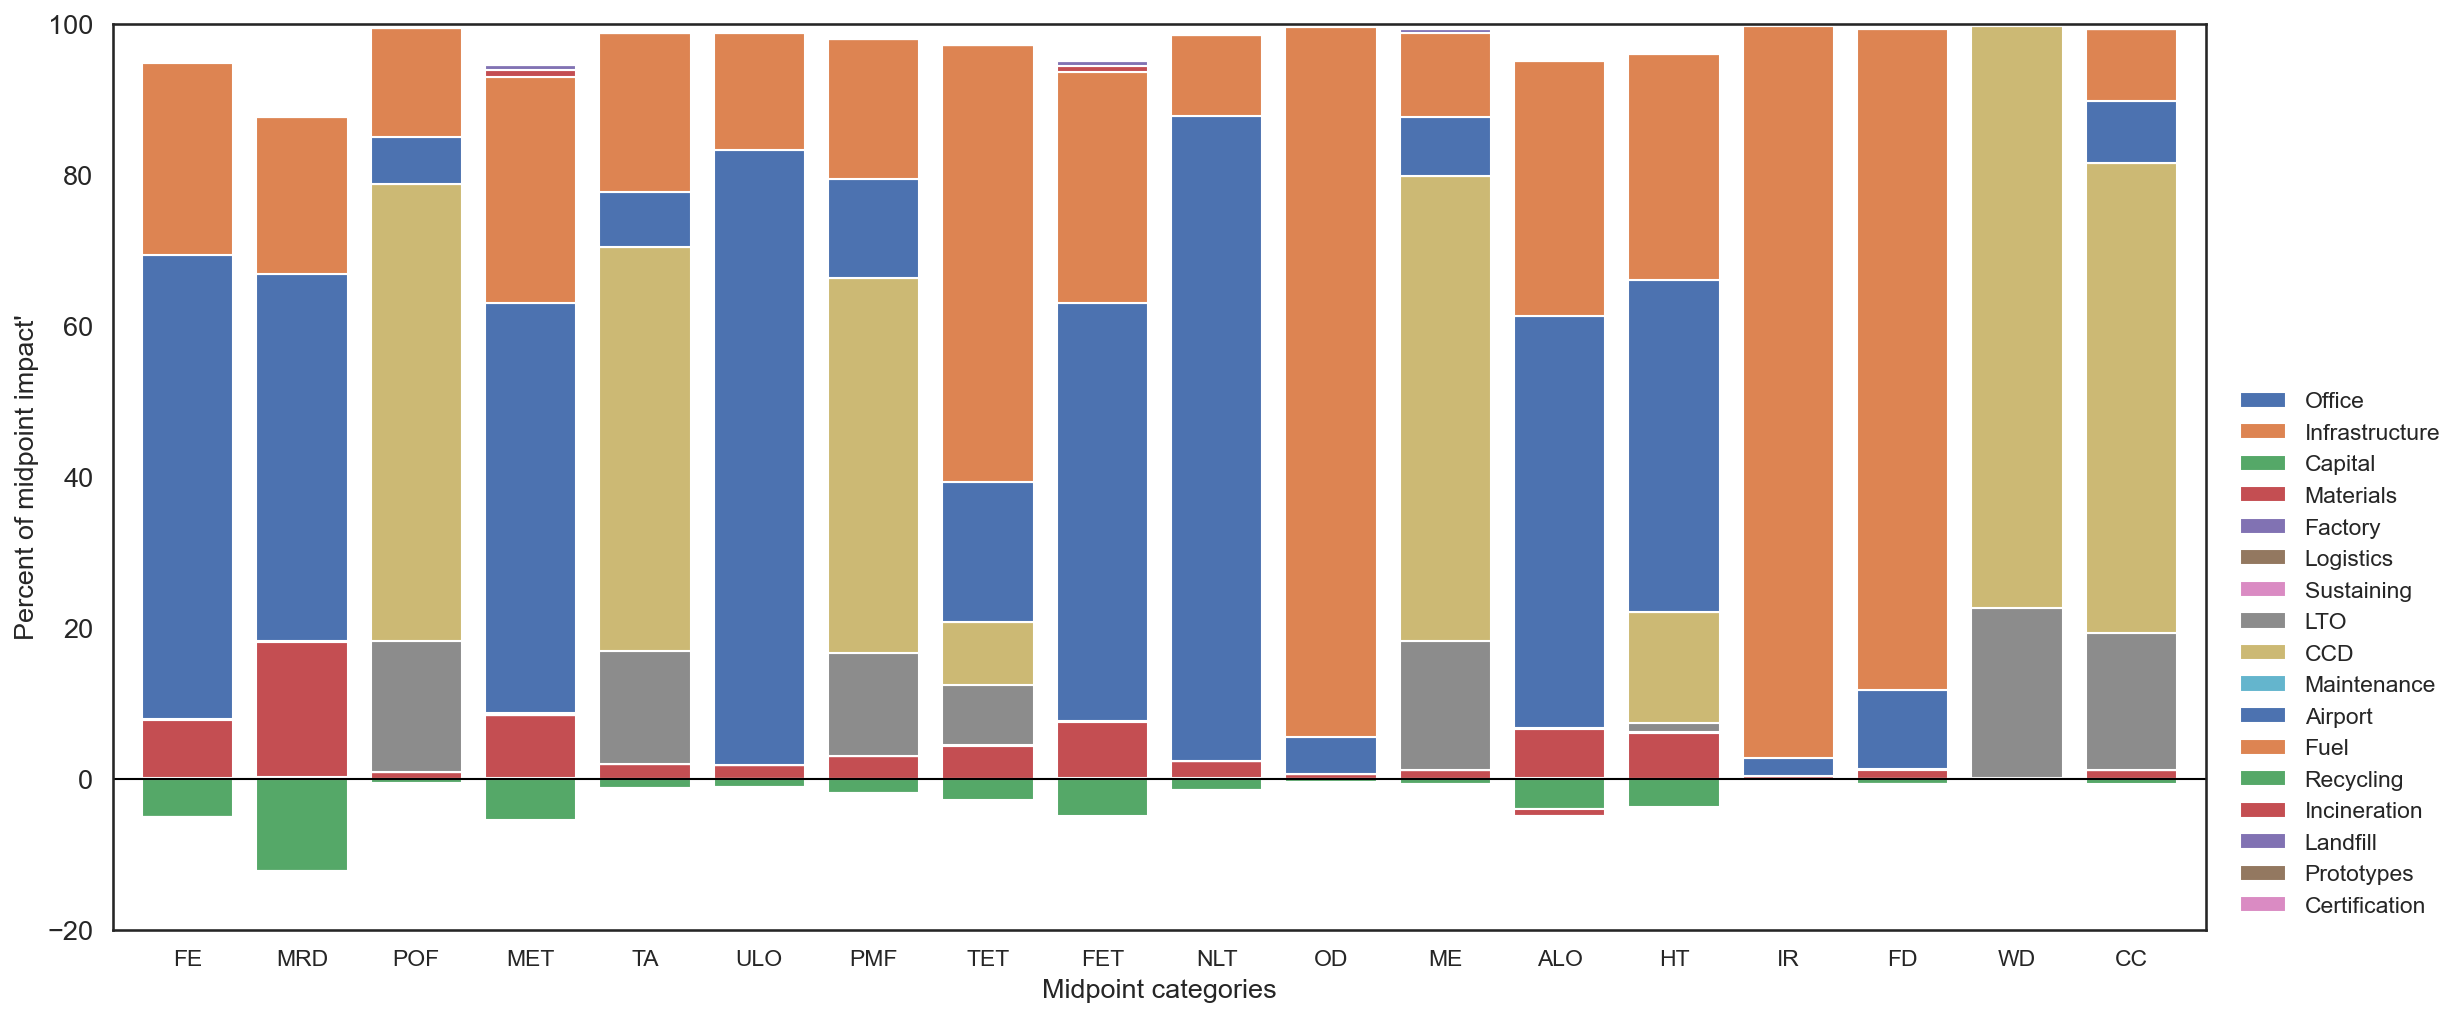

In [9]:
aeco.bar('MP', subphase=True, save=False)

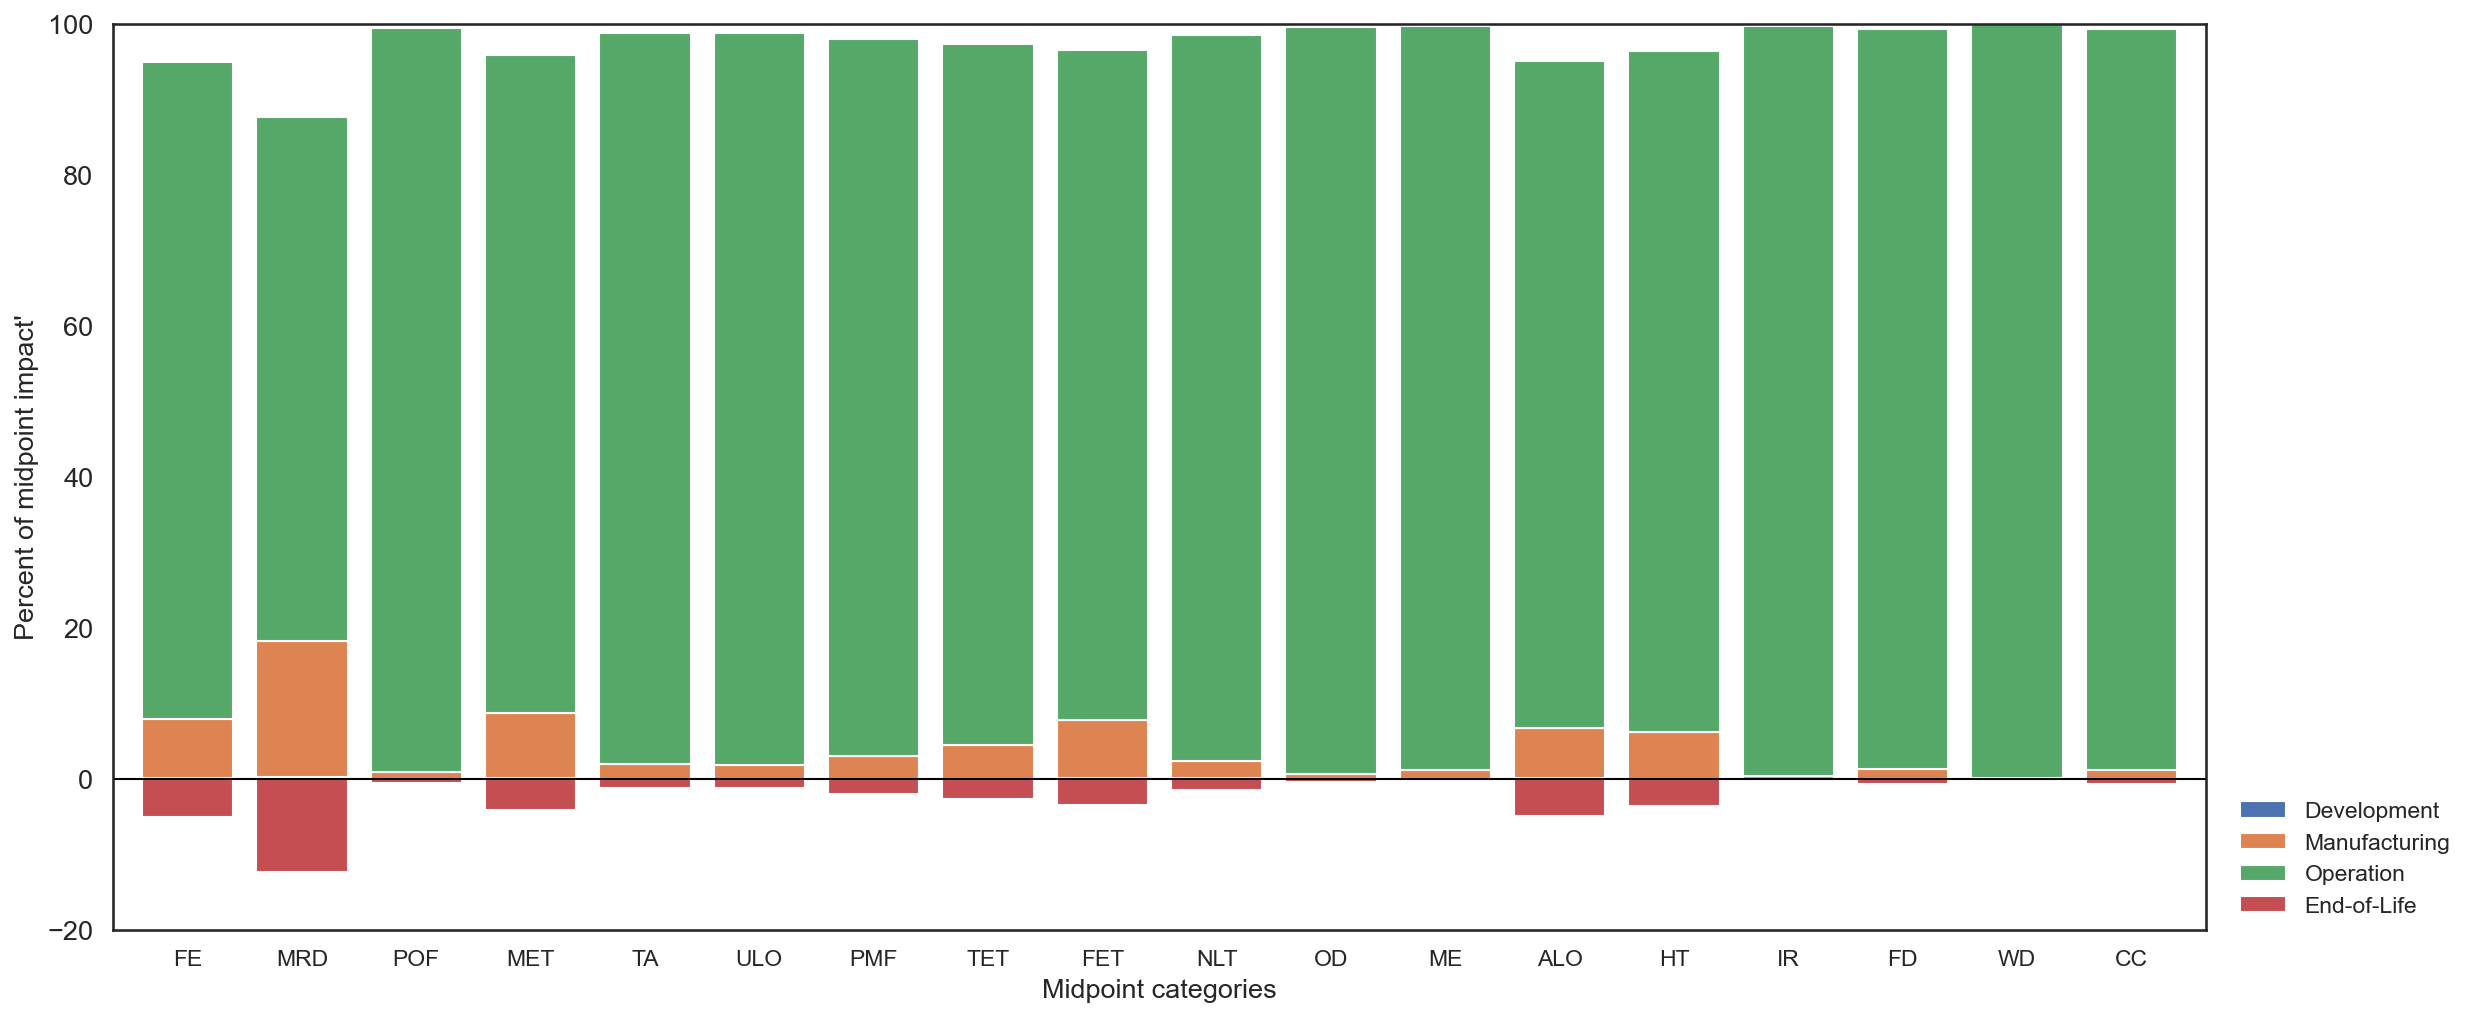

In [148]:
aeco.bar('MP', subphase=False, save=False)

# Endpoint Results

The distributions of the endpoint results, considering all the iterations, are plotted for each impact category using the `LCIA.dist()` method.

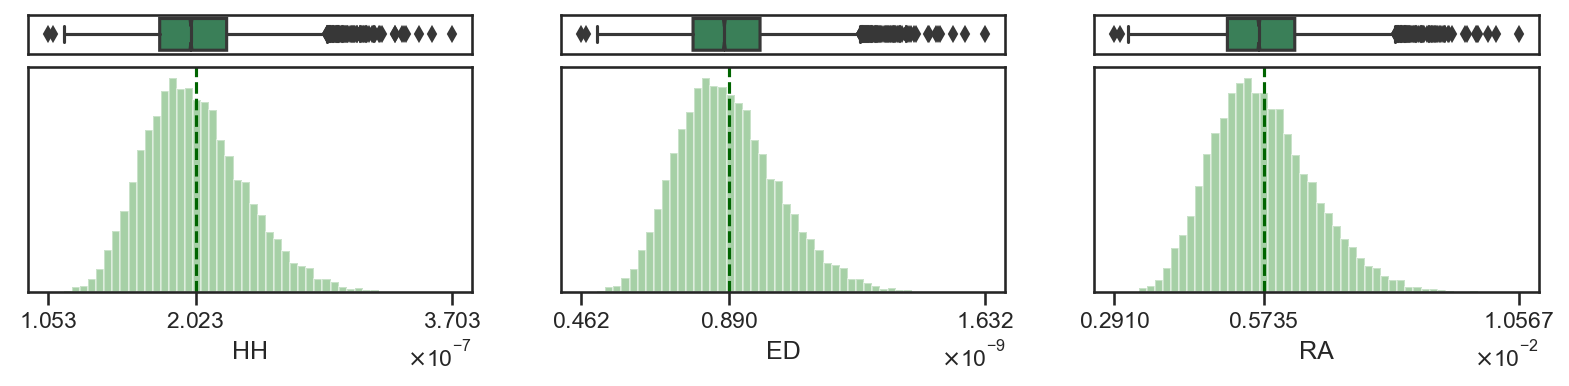

In [149]:
aeco.dist('EP', save=False)

Mean endpoint results are shown below.

In [151]:
aeco.mean('EP', by='sum').compute()

<xarray.DataArray 'stack-47c42dd5c18d2c55f459d3b15651463a' (AOP: 3)>
array([2.02288636e-07, 8.90226357e-10, 5.73493143e-03])
Coordinates:
  * AOP      (AOP) object 'HH' 'ED' 'RA'

Endpoint impacts per life cycle phase are plotted with the `LCIA.bar()` method.

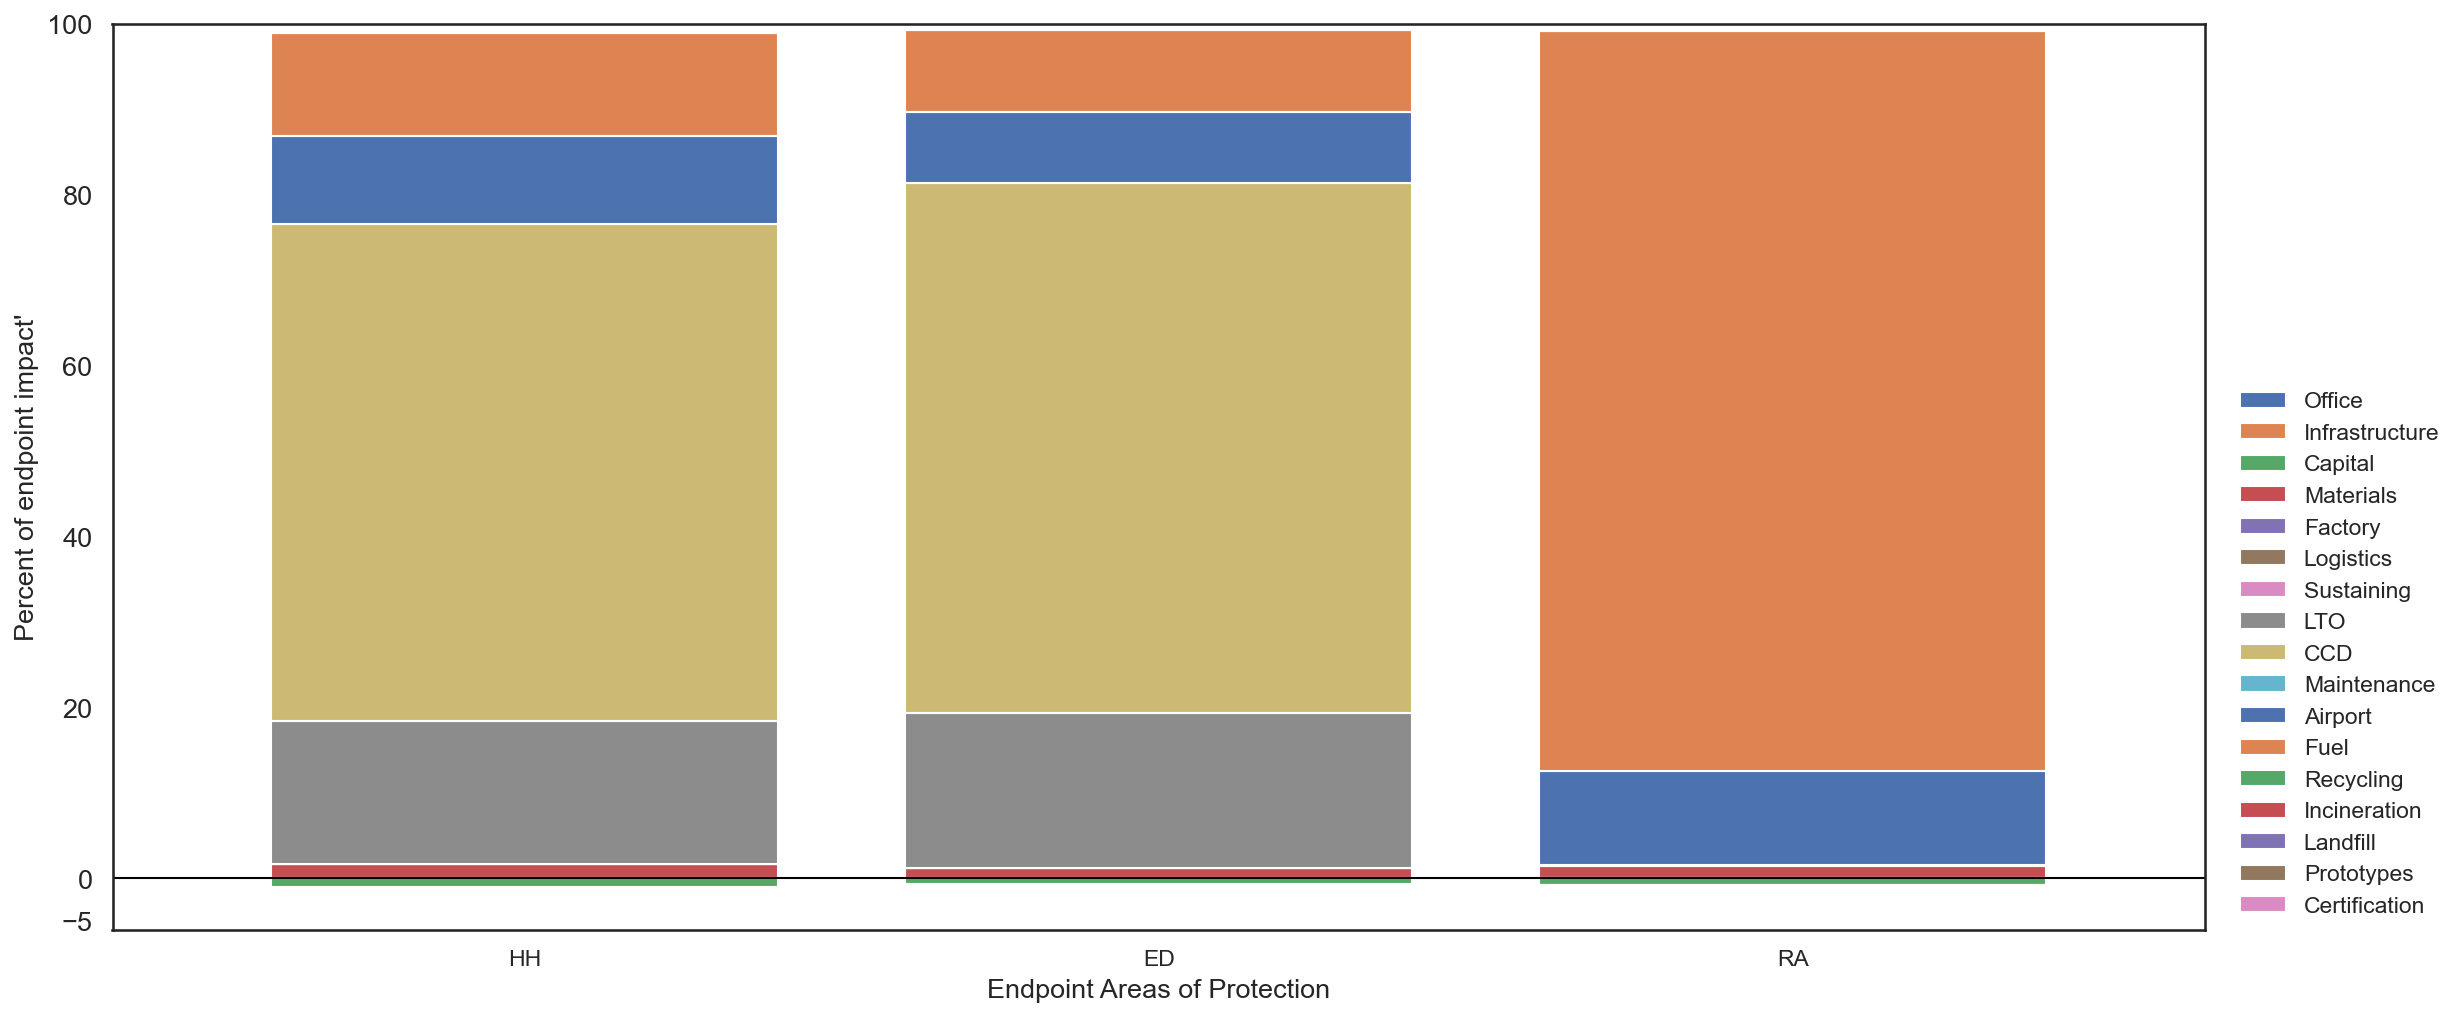

In [147]:
aeco.bar('EP', subphase=True, save=False)

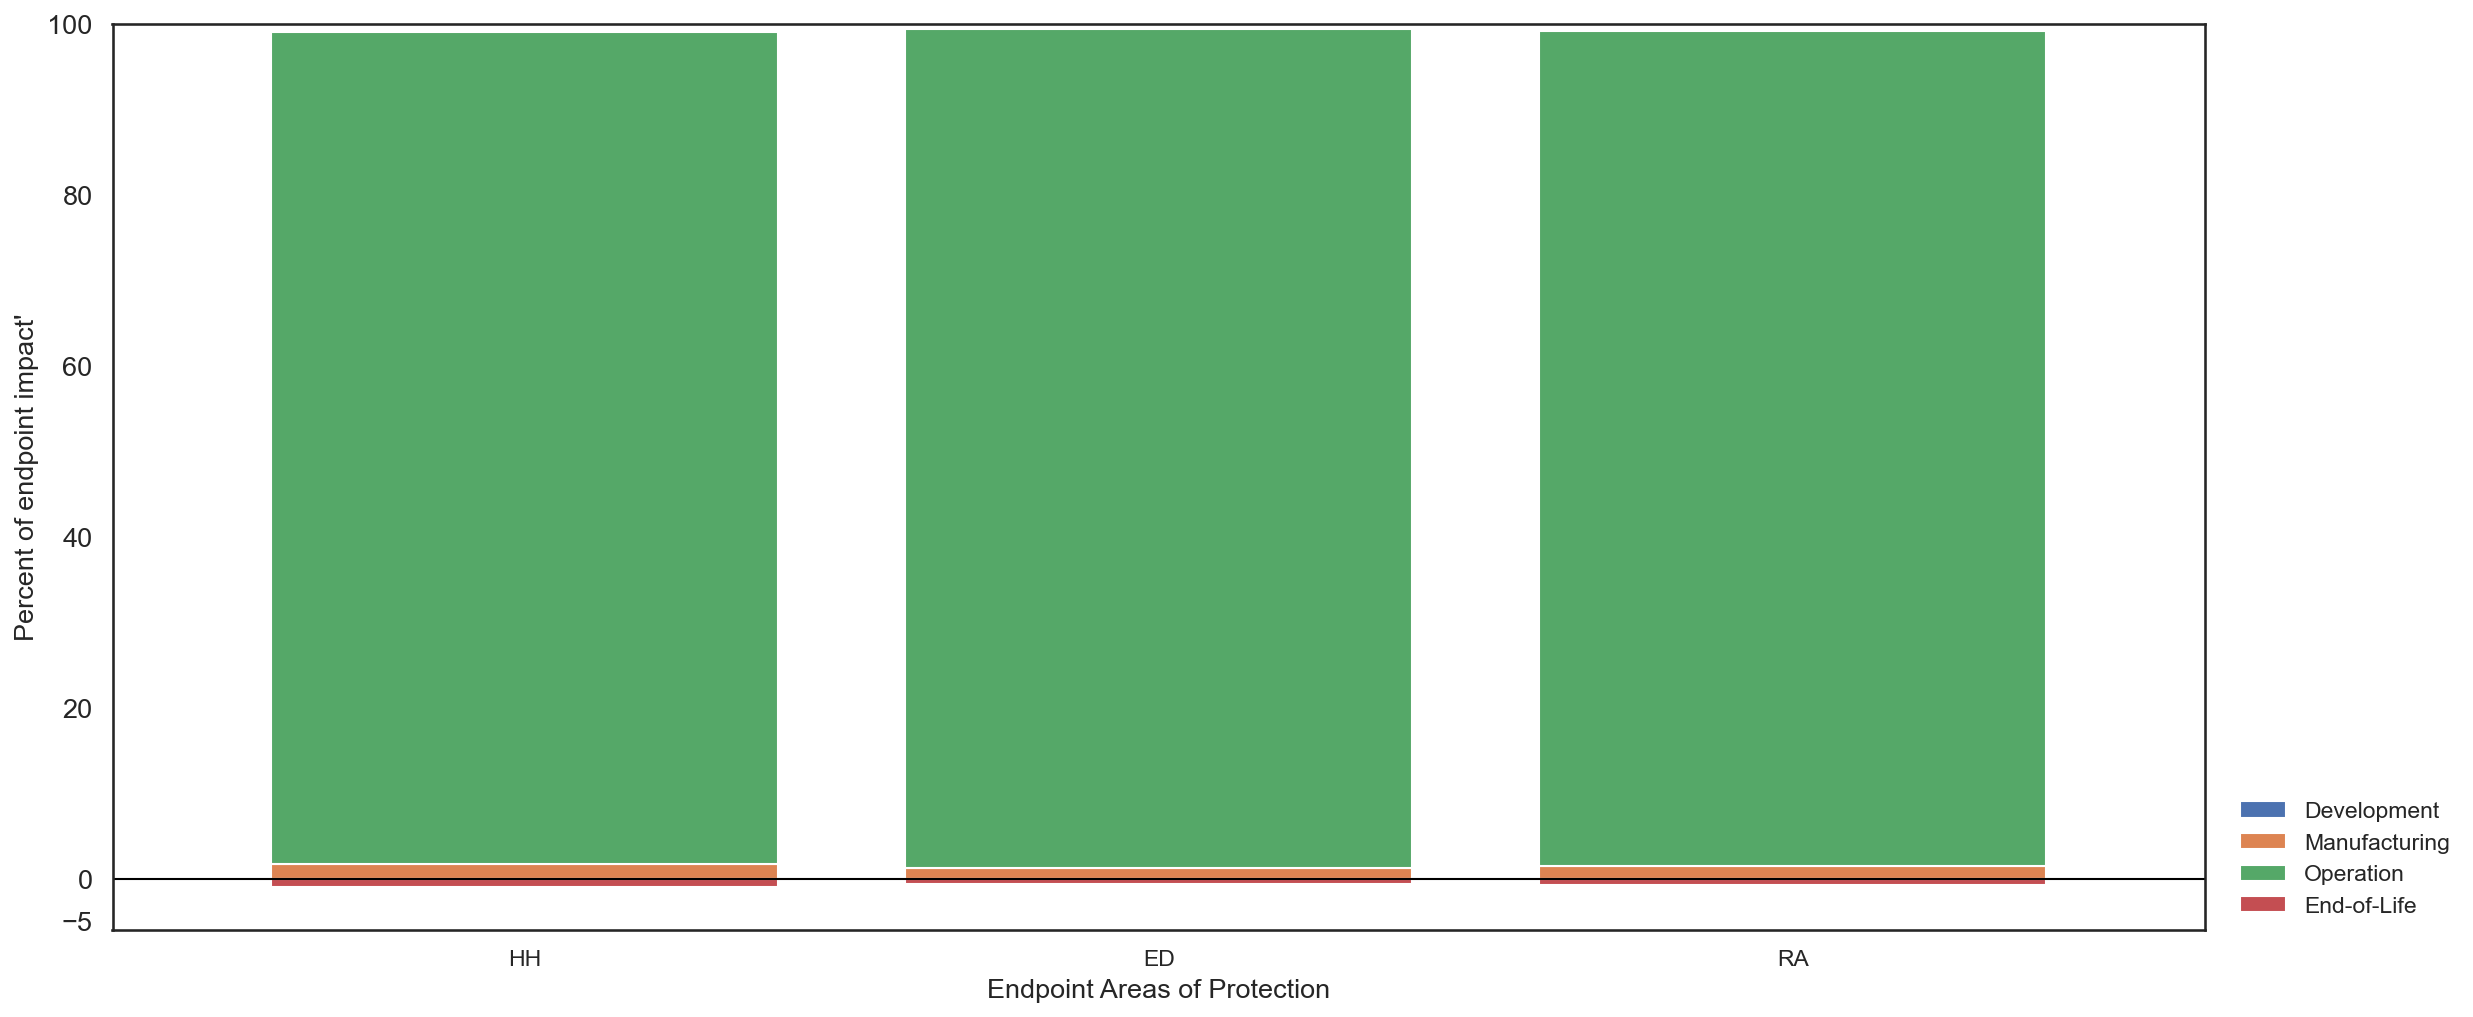

In [150]:
aeco.bar('EP', subphase=False, save=False)

# Single Score Results

Mean SS results are shown below.

In [6]:
aeco.SS("sum").mean('i').compute()

<xarray.DataArray ()>
array(0.02810226)

# CTV Results

The areas in the following plots represent CTV for each input parameters. Each plot concerns one midpoint or endpoint result. This plot is accessed through the `LCIA.square()` method.

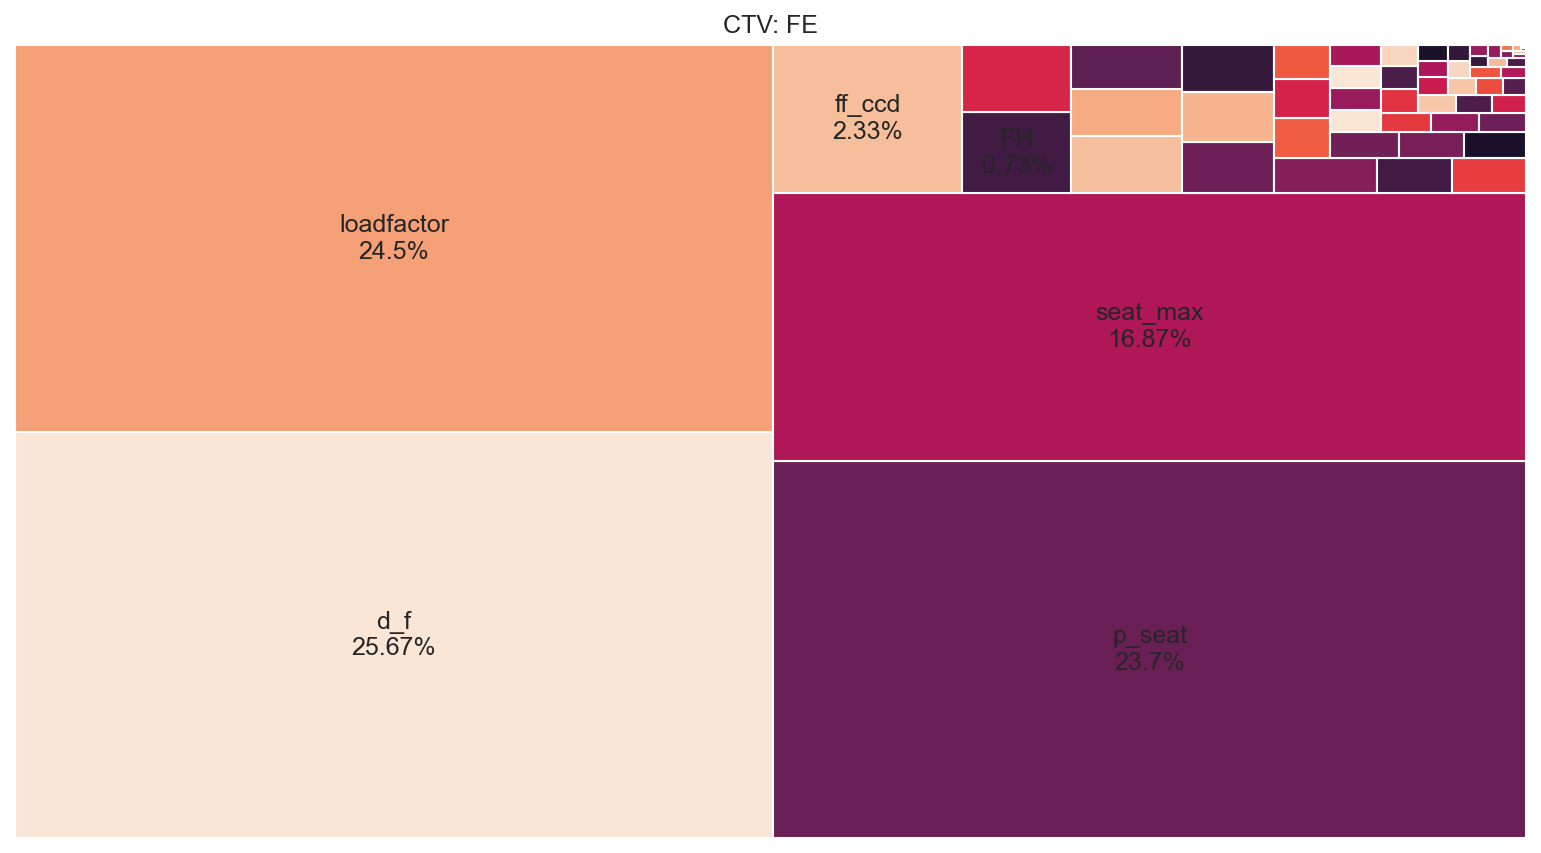

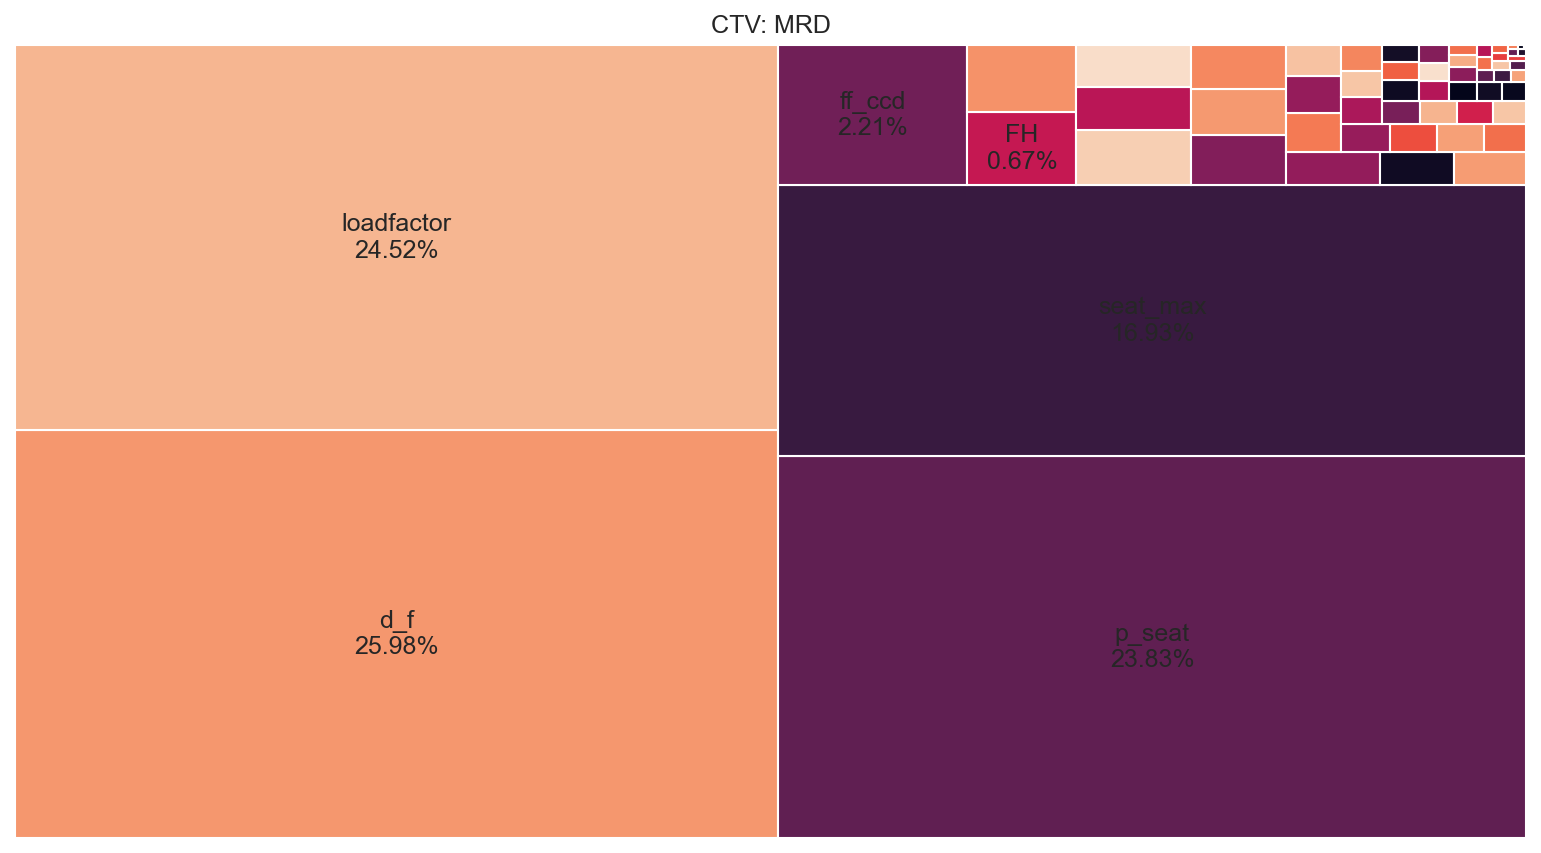

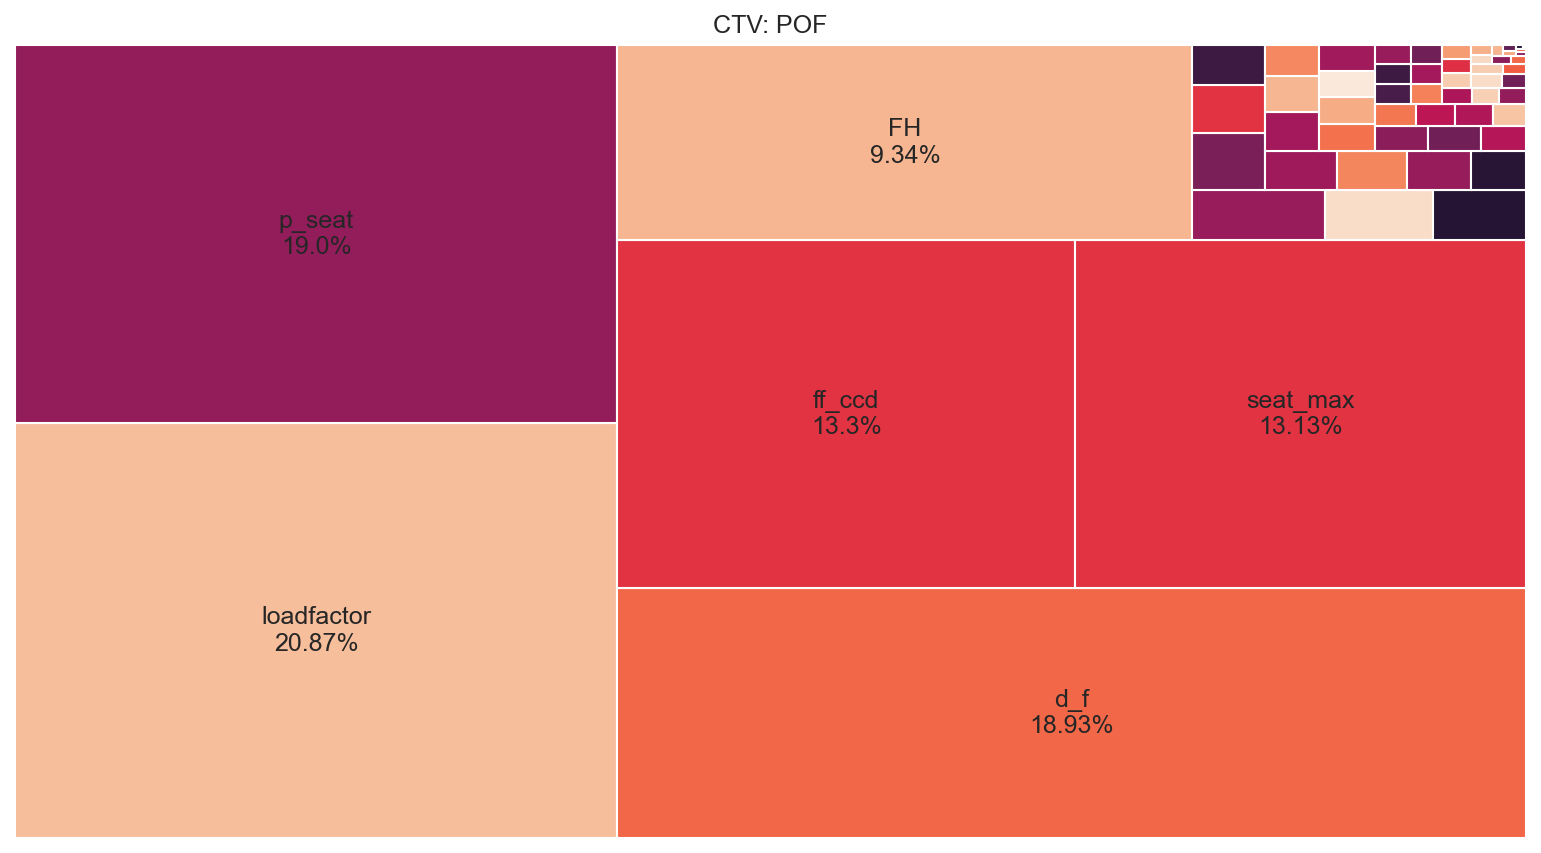

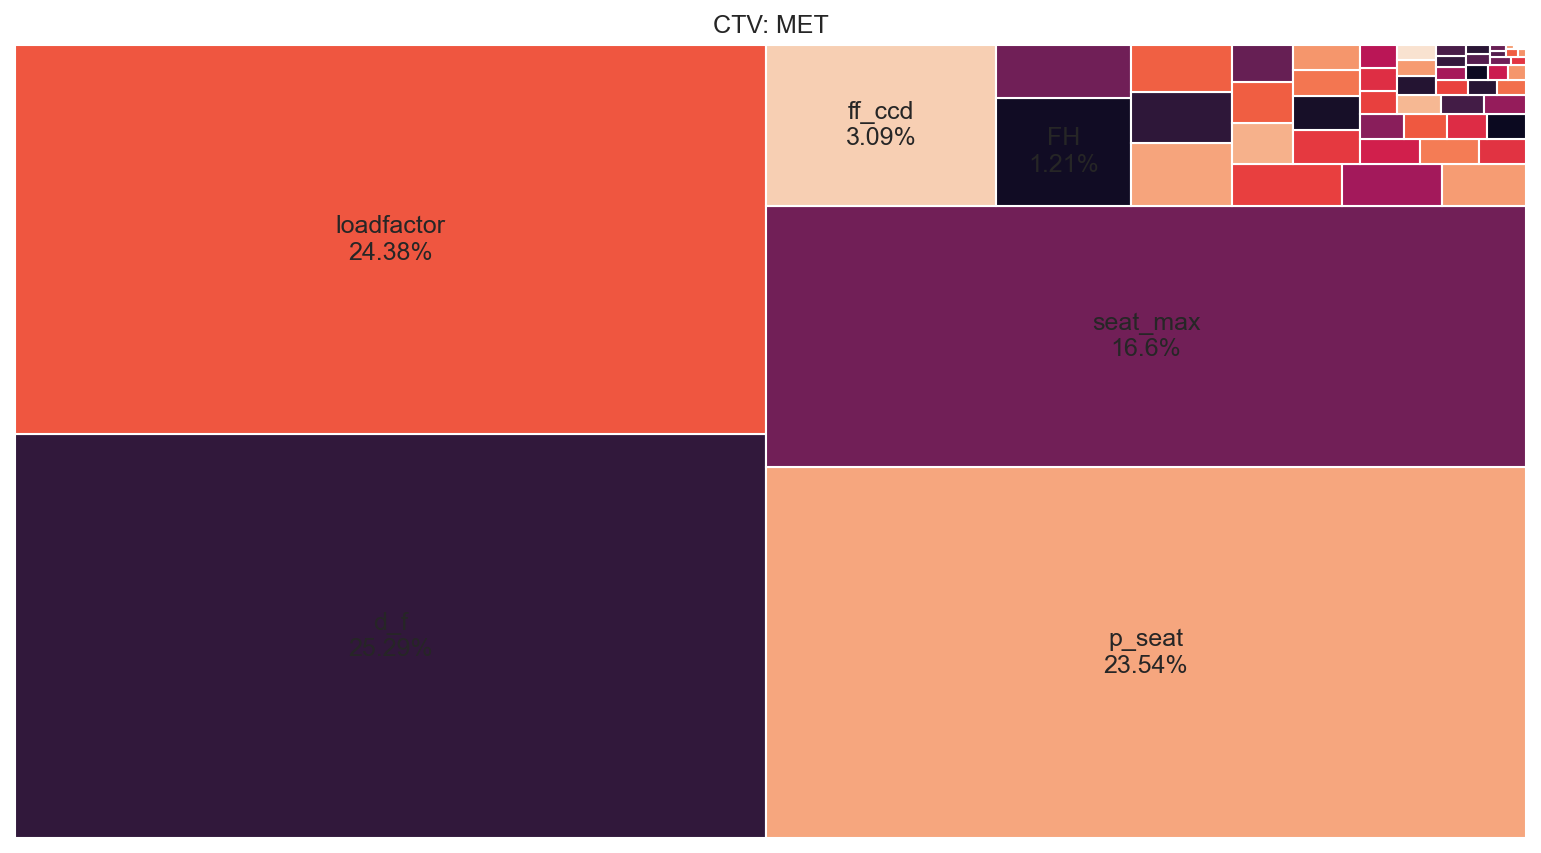

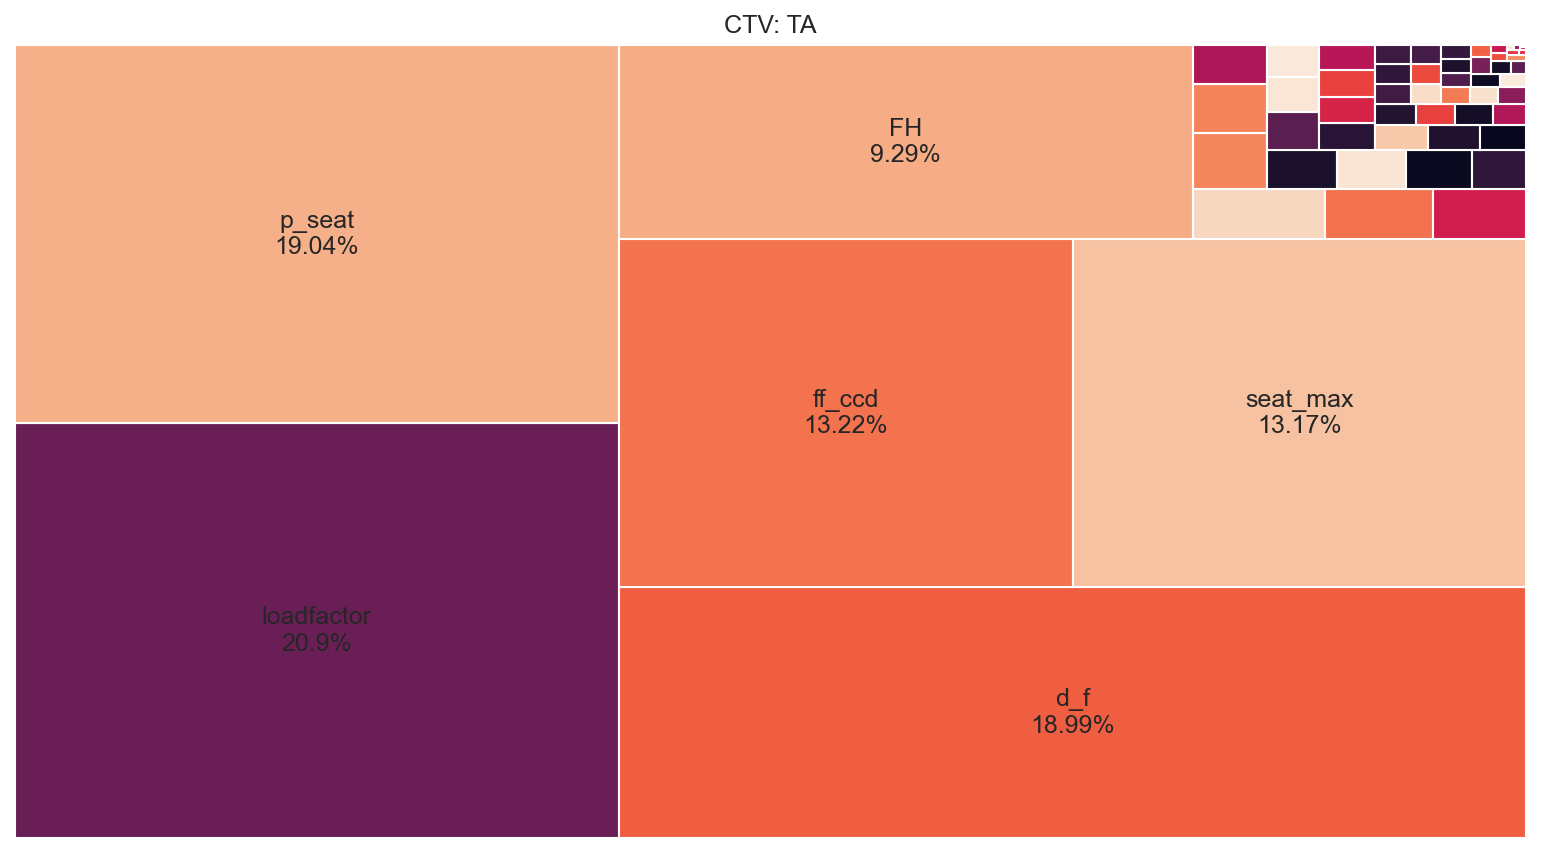

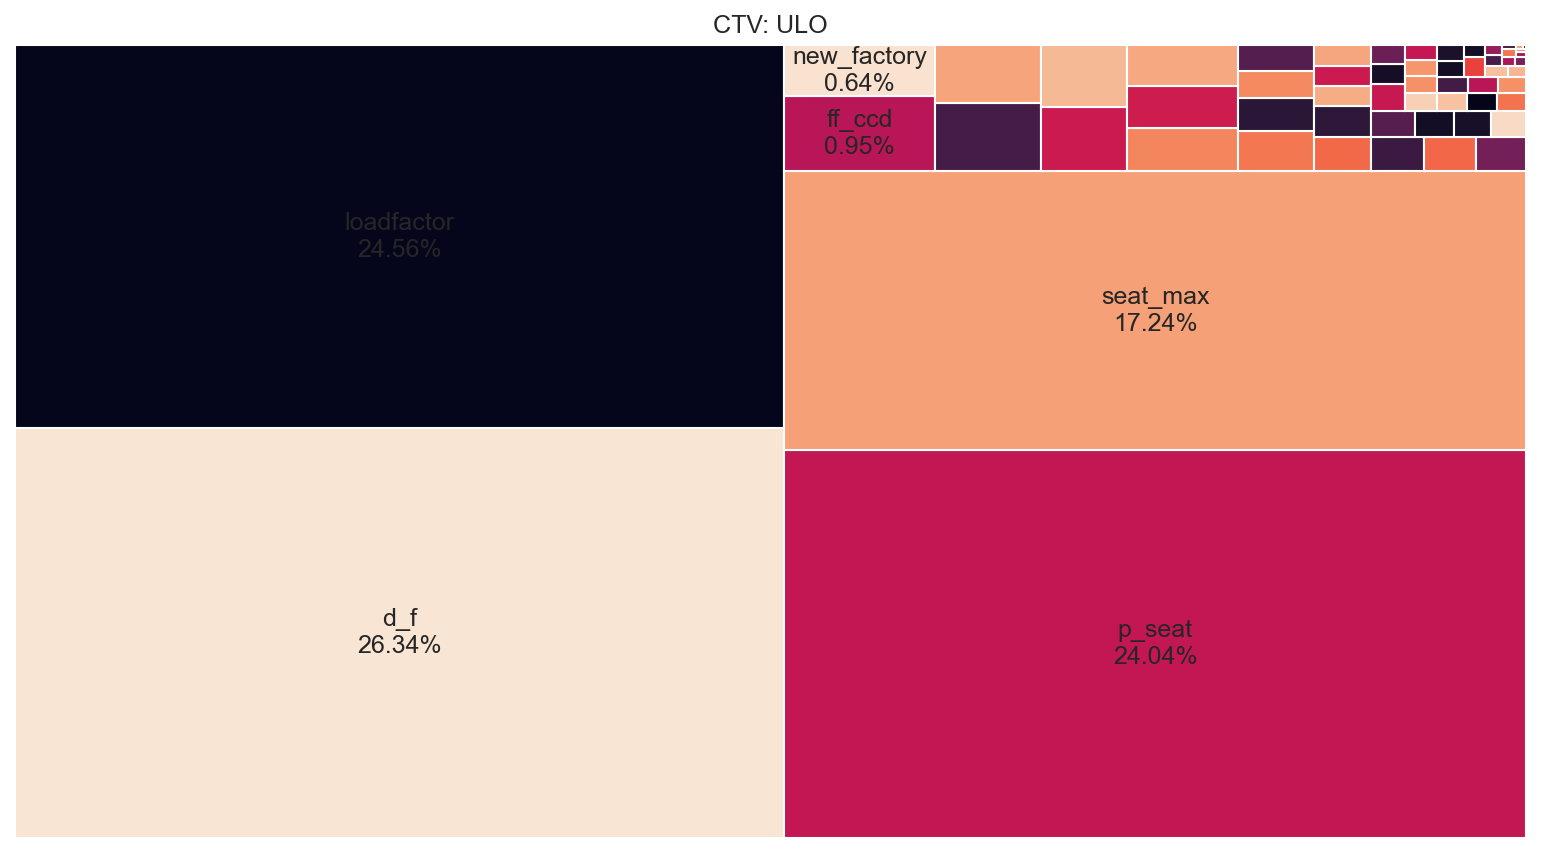

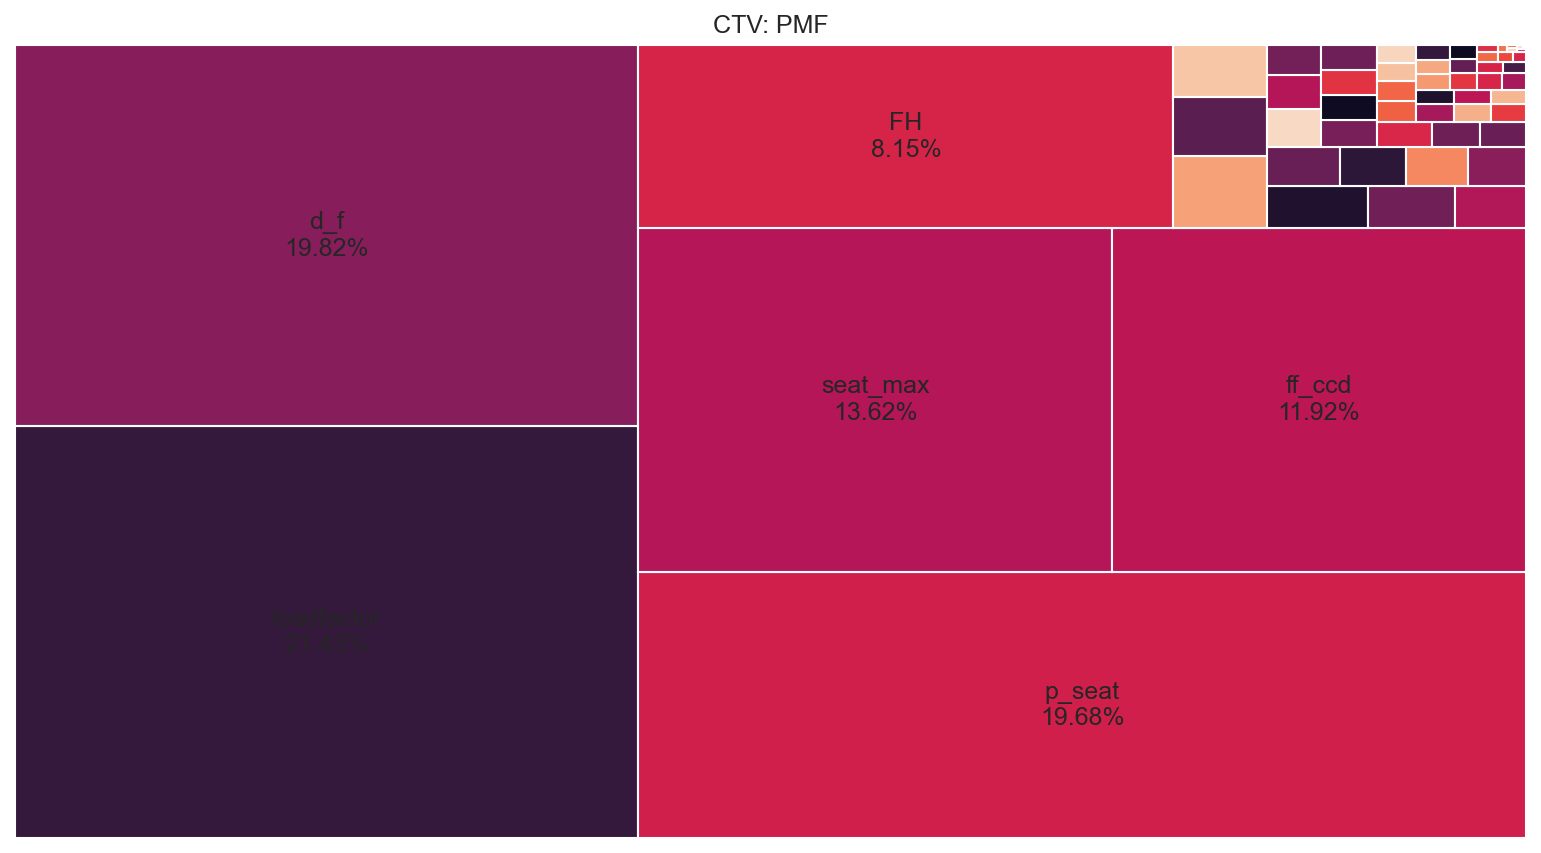

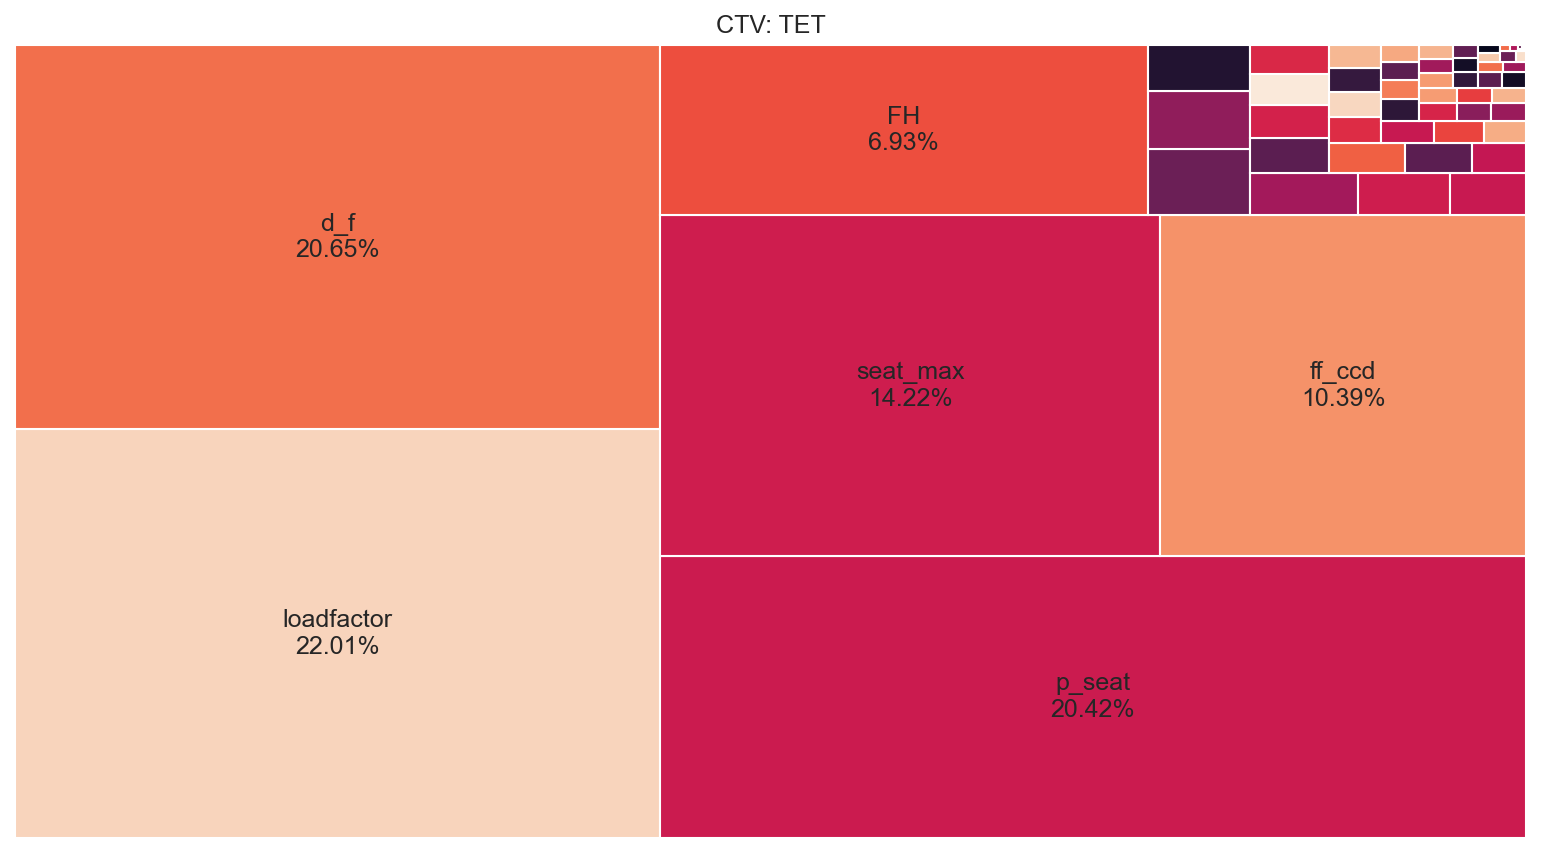

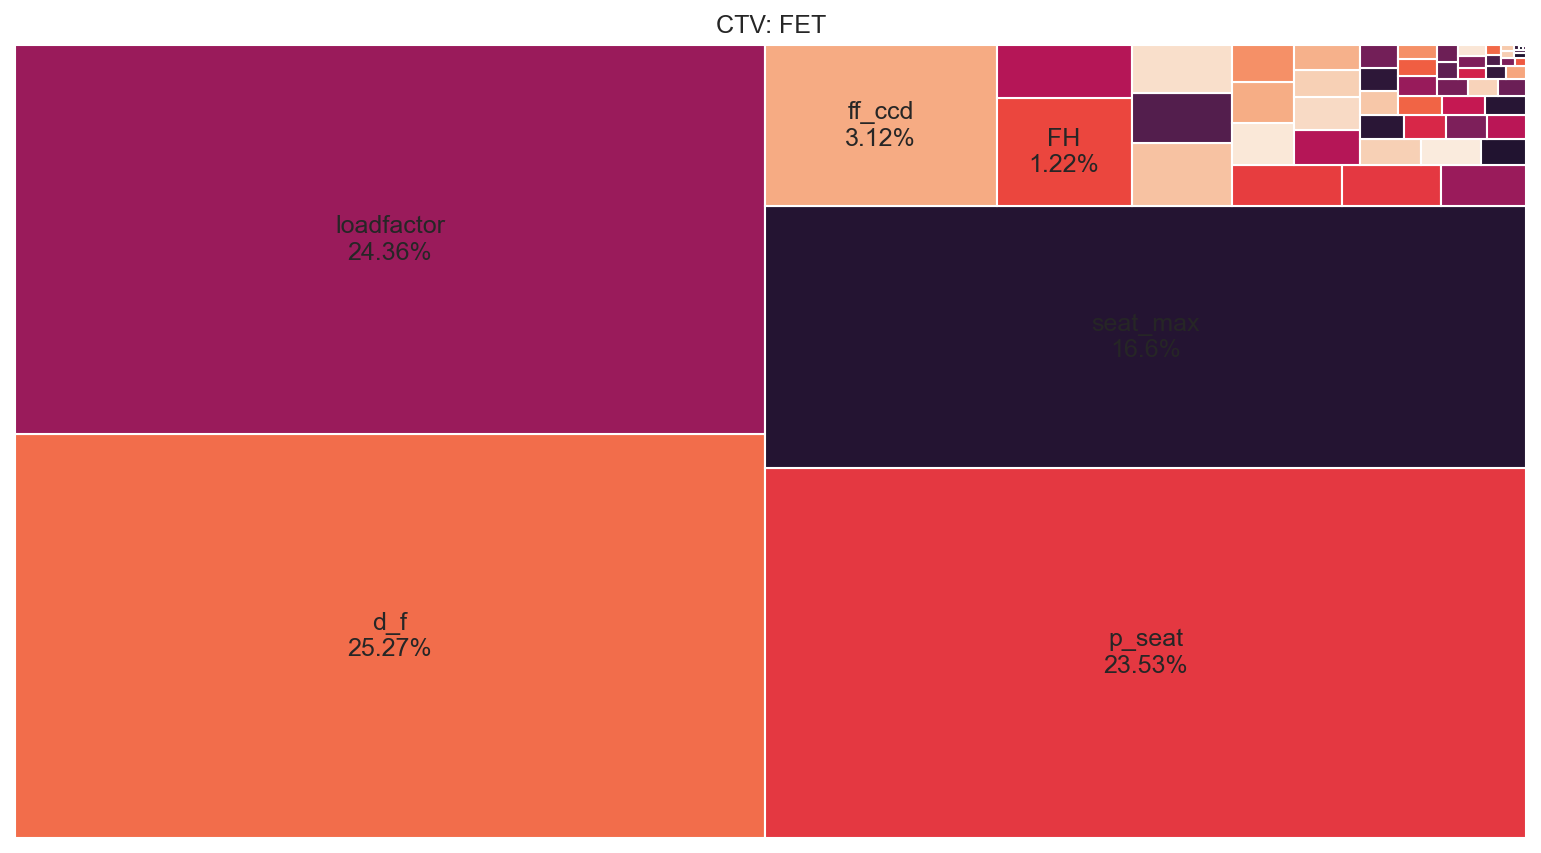

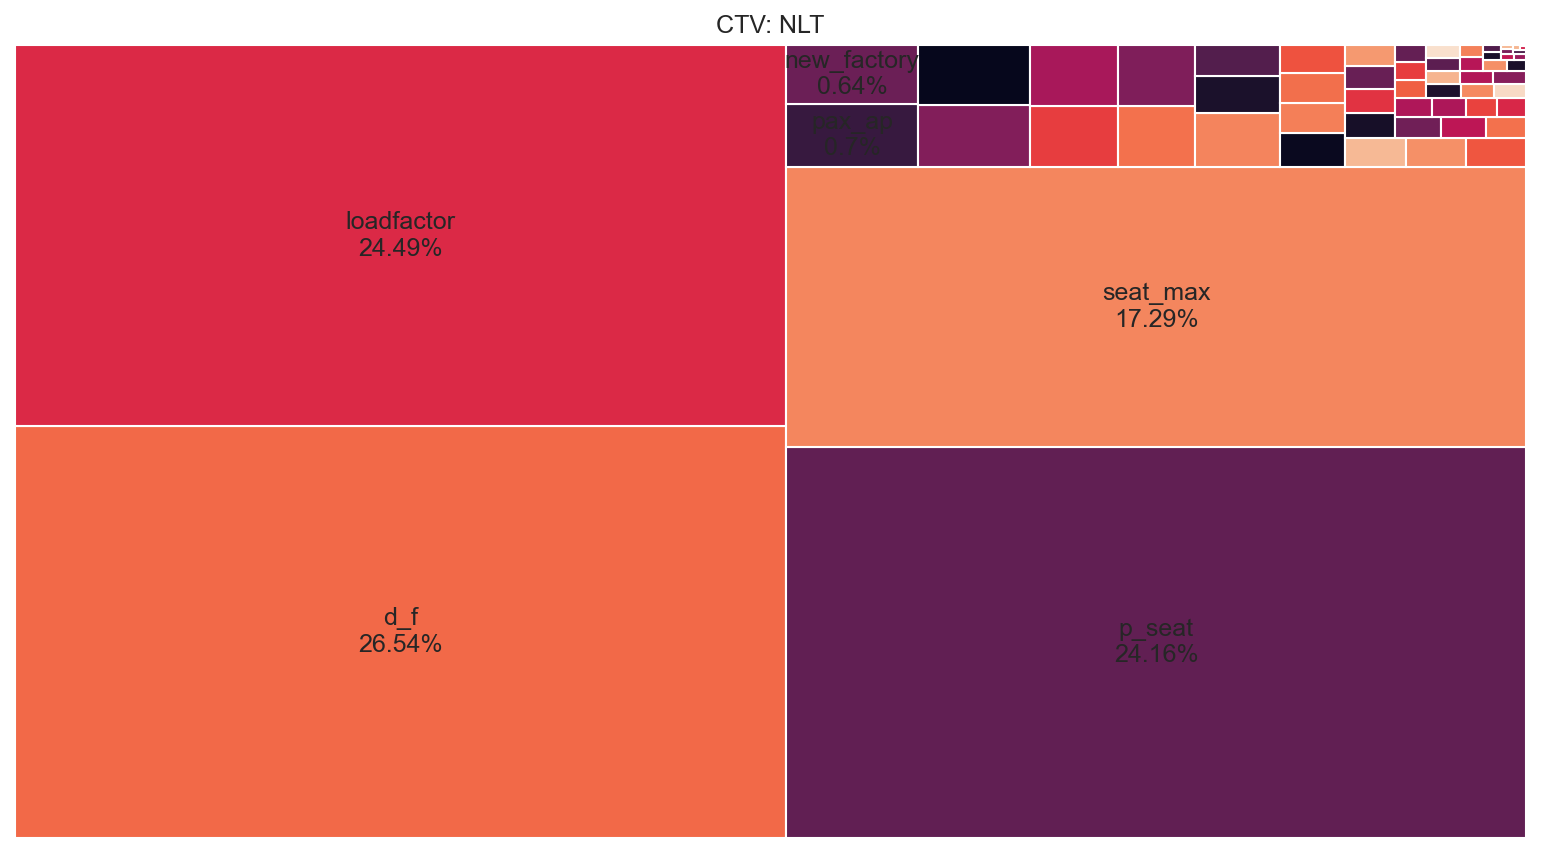

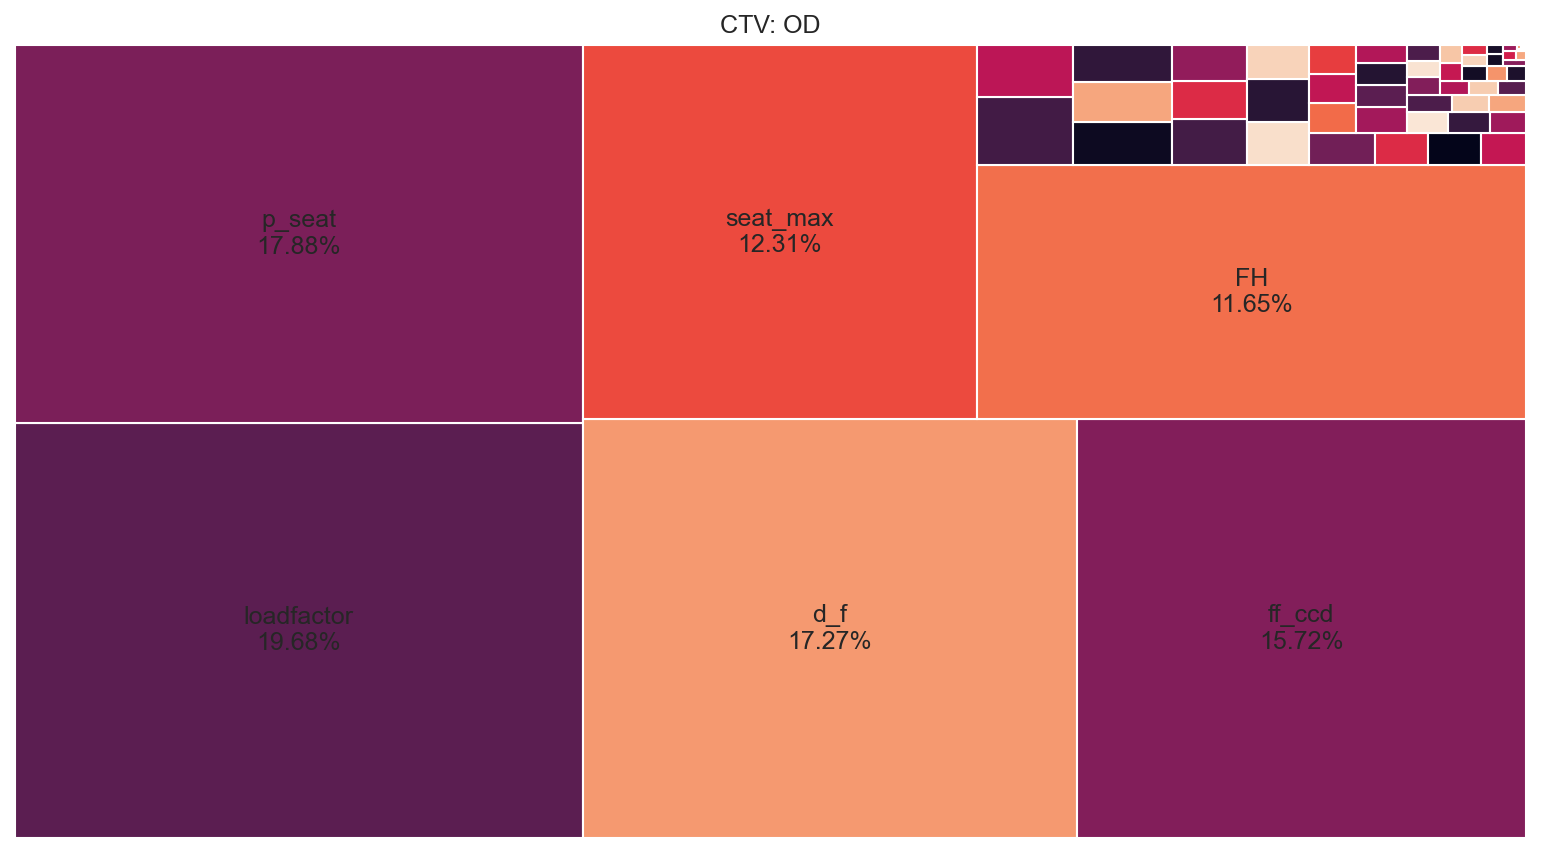

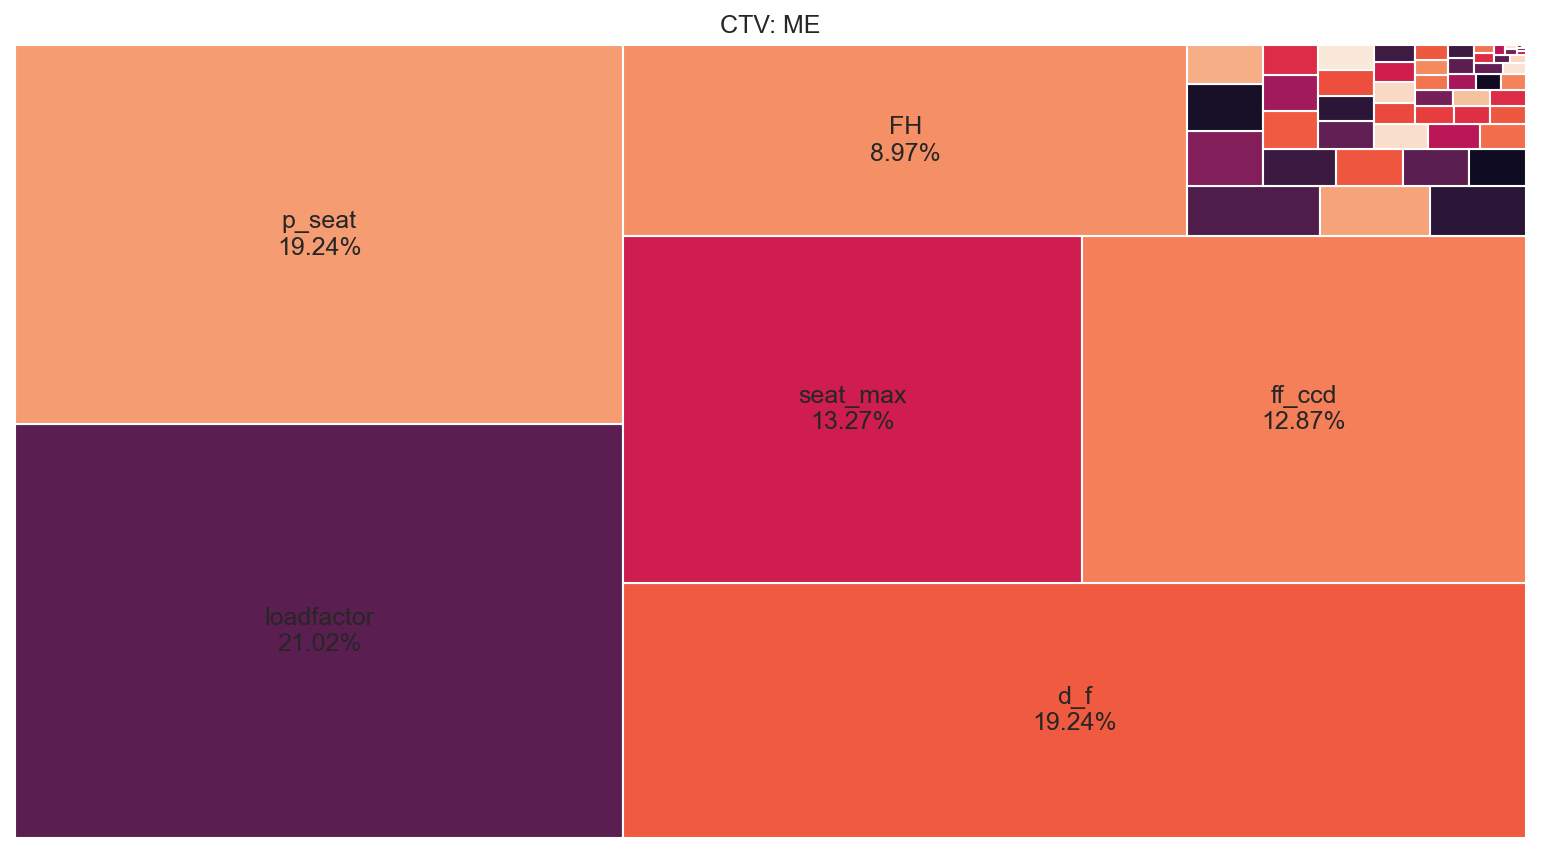

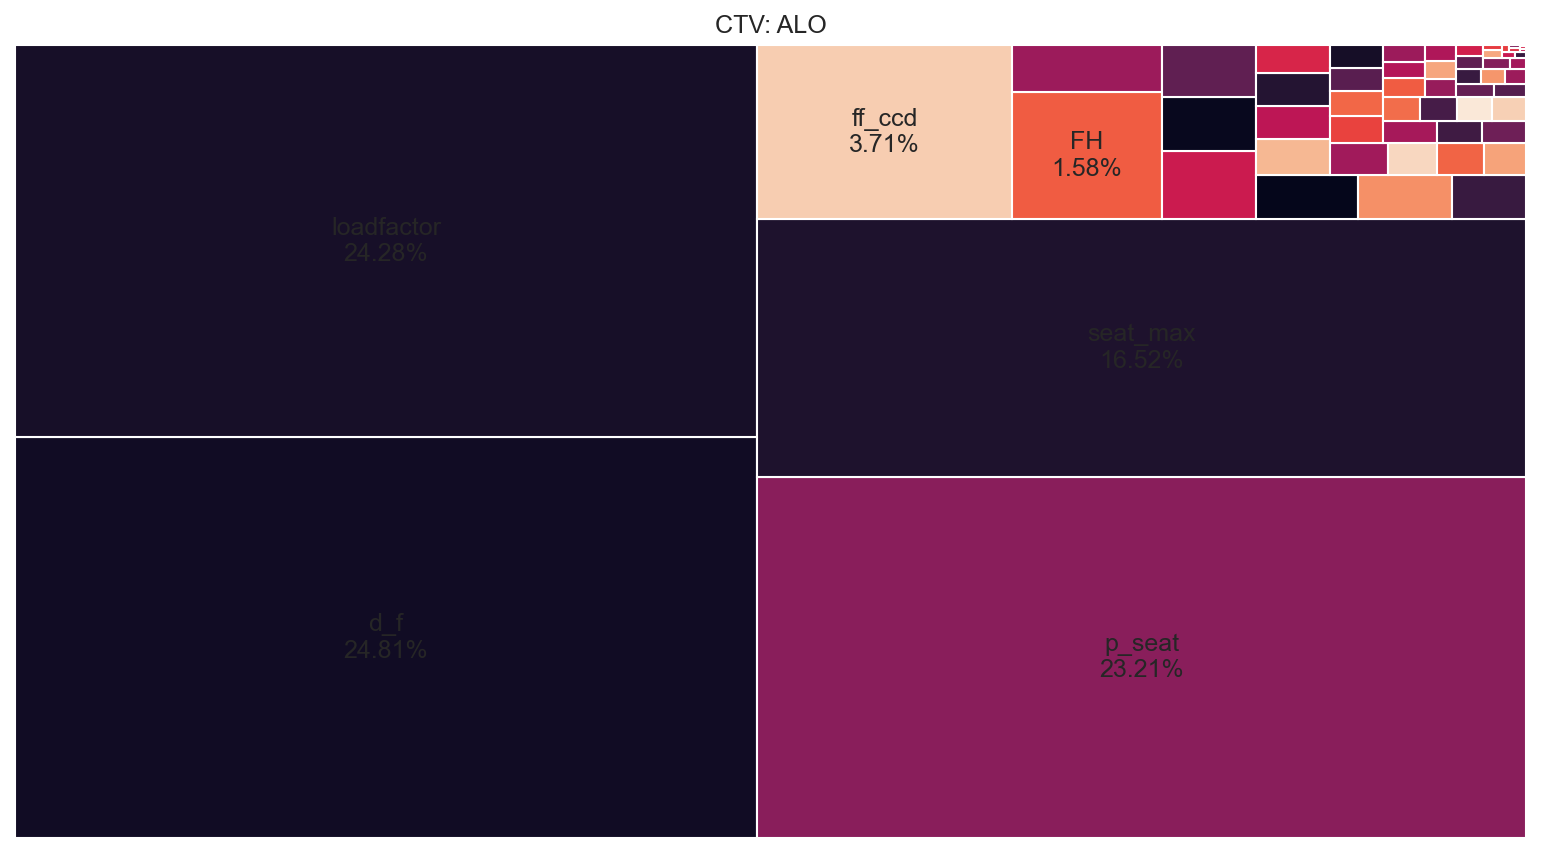

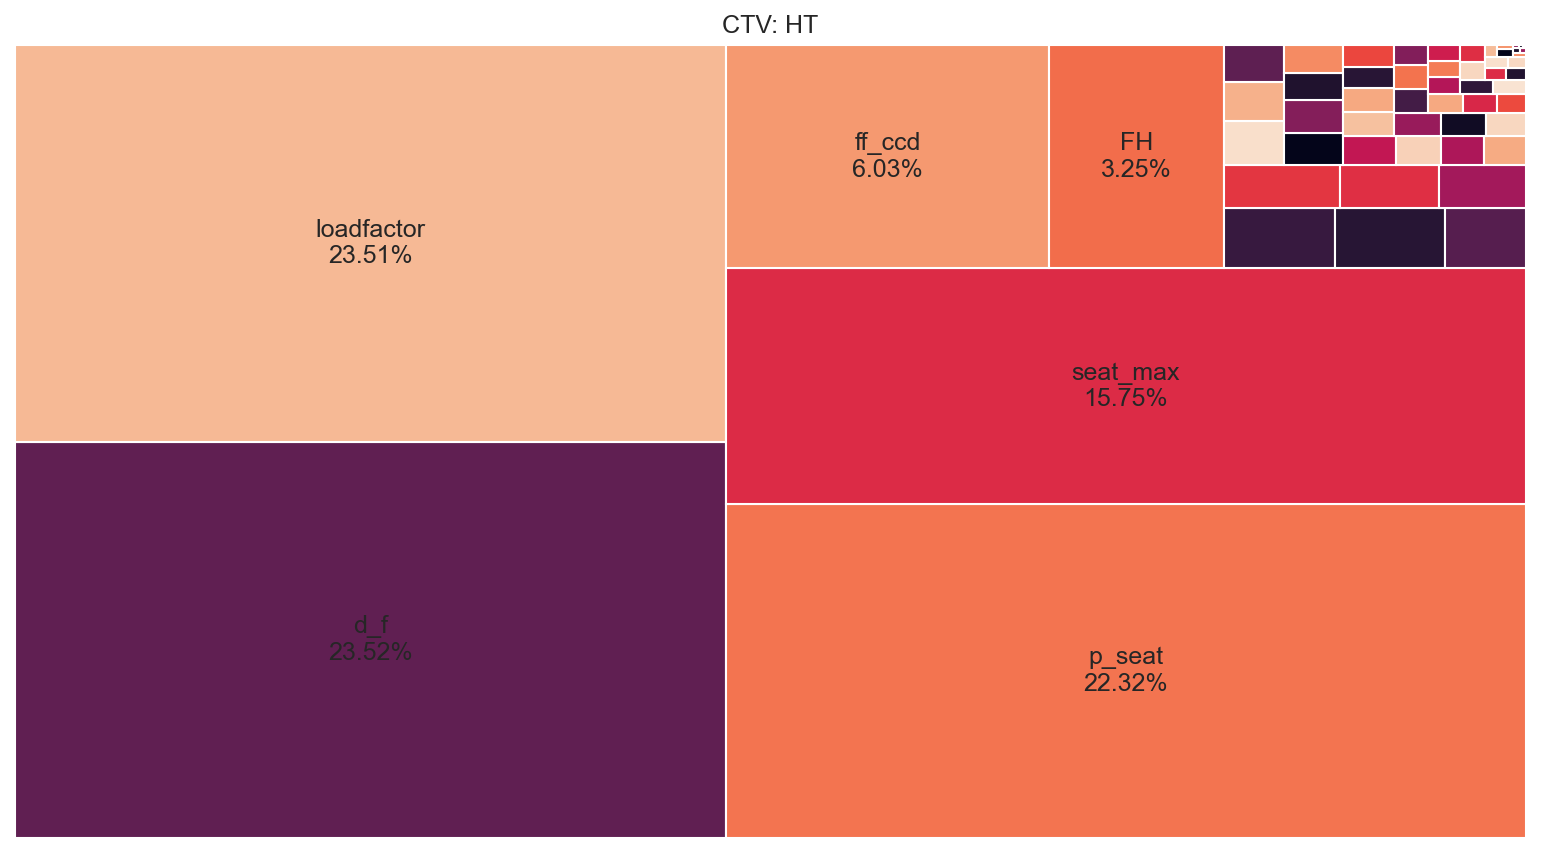

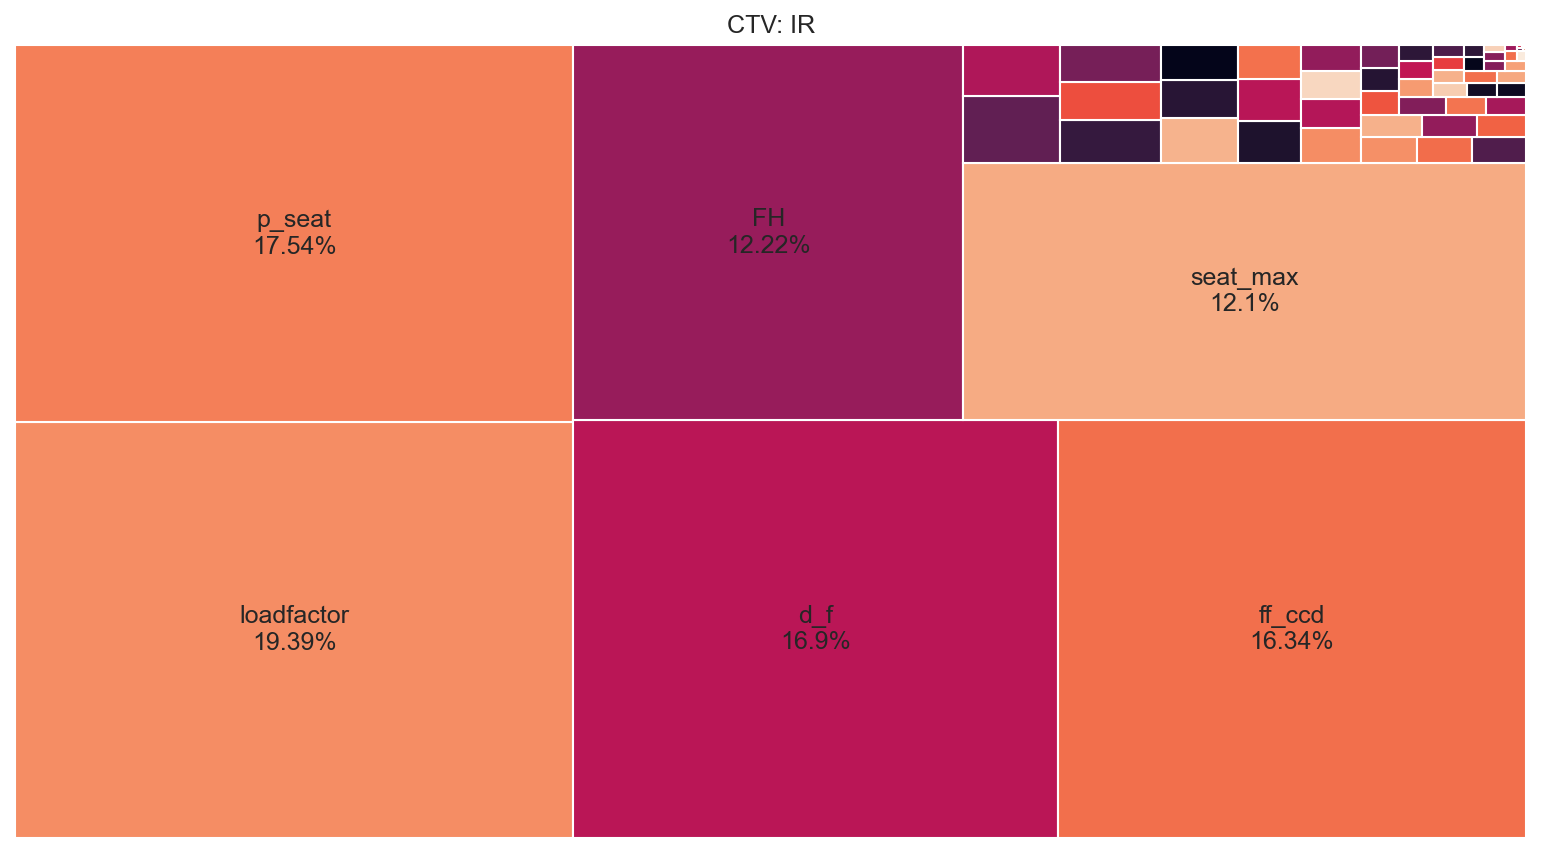

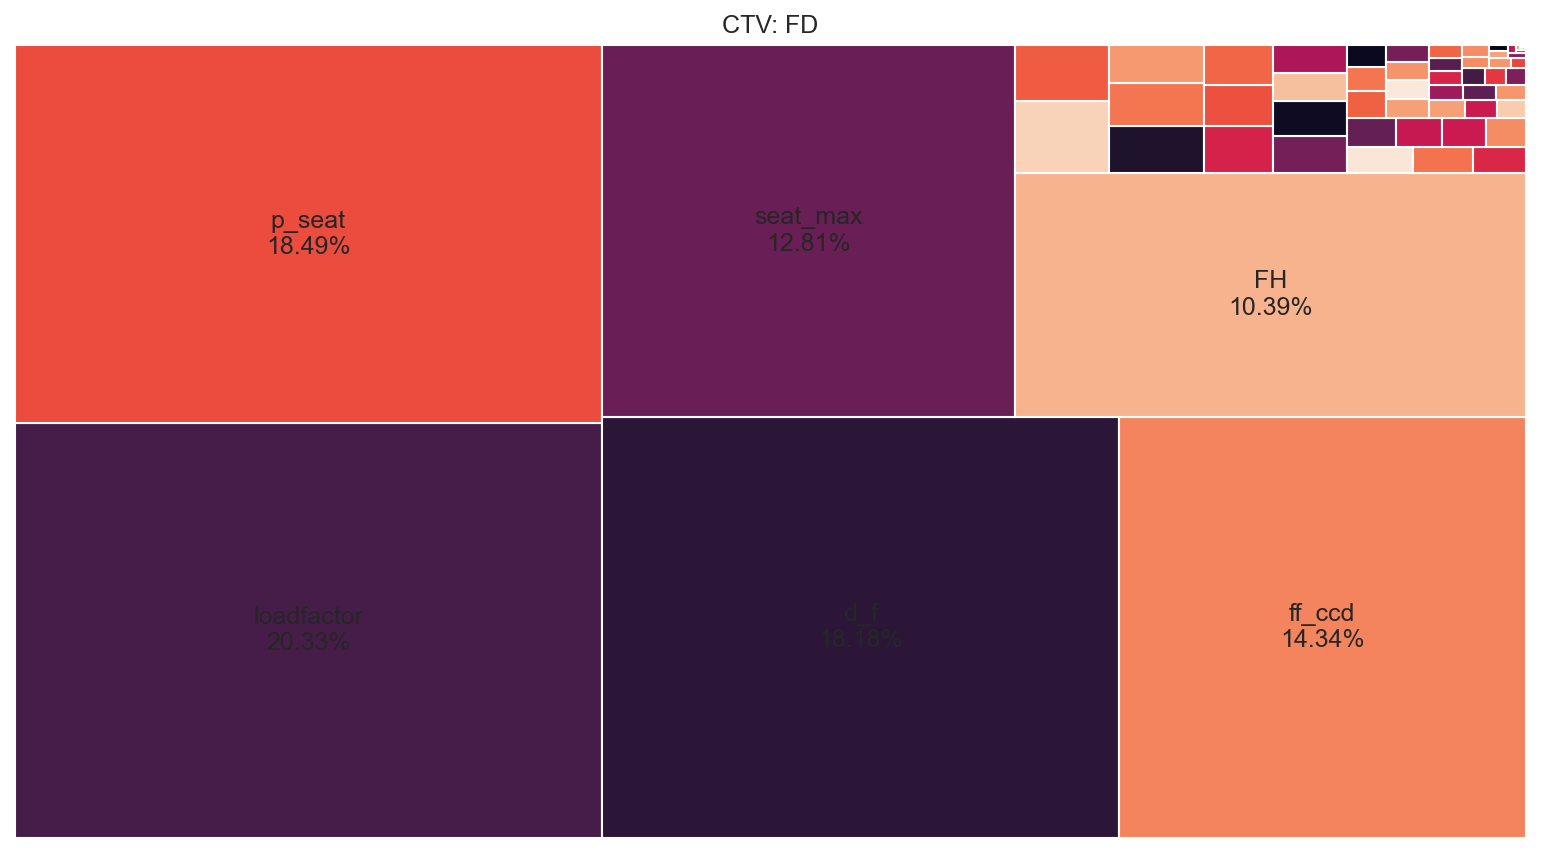

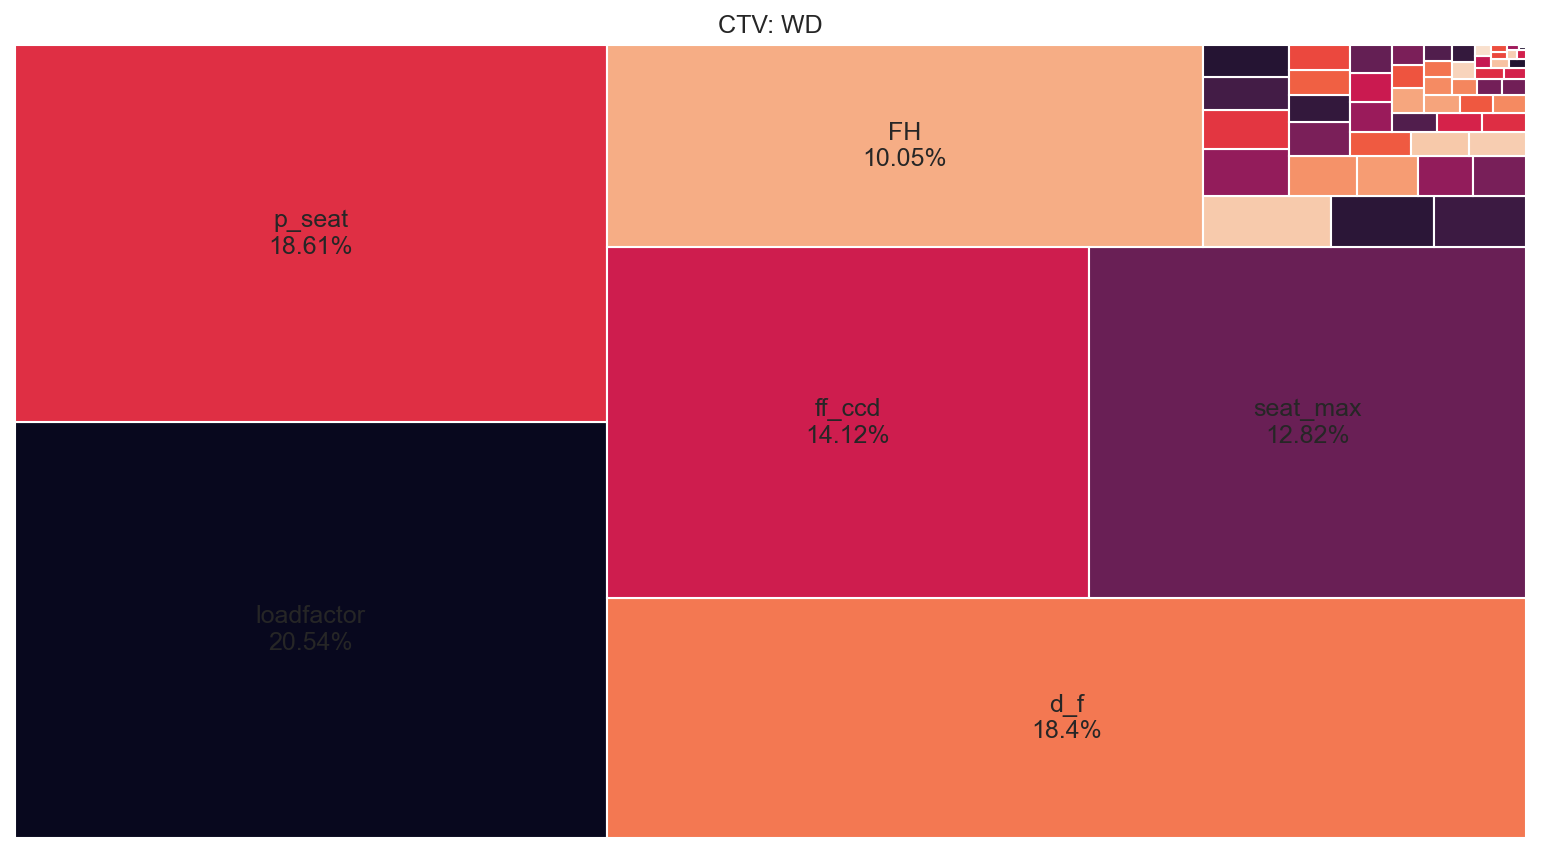

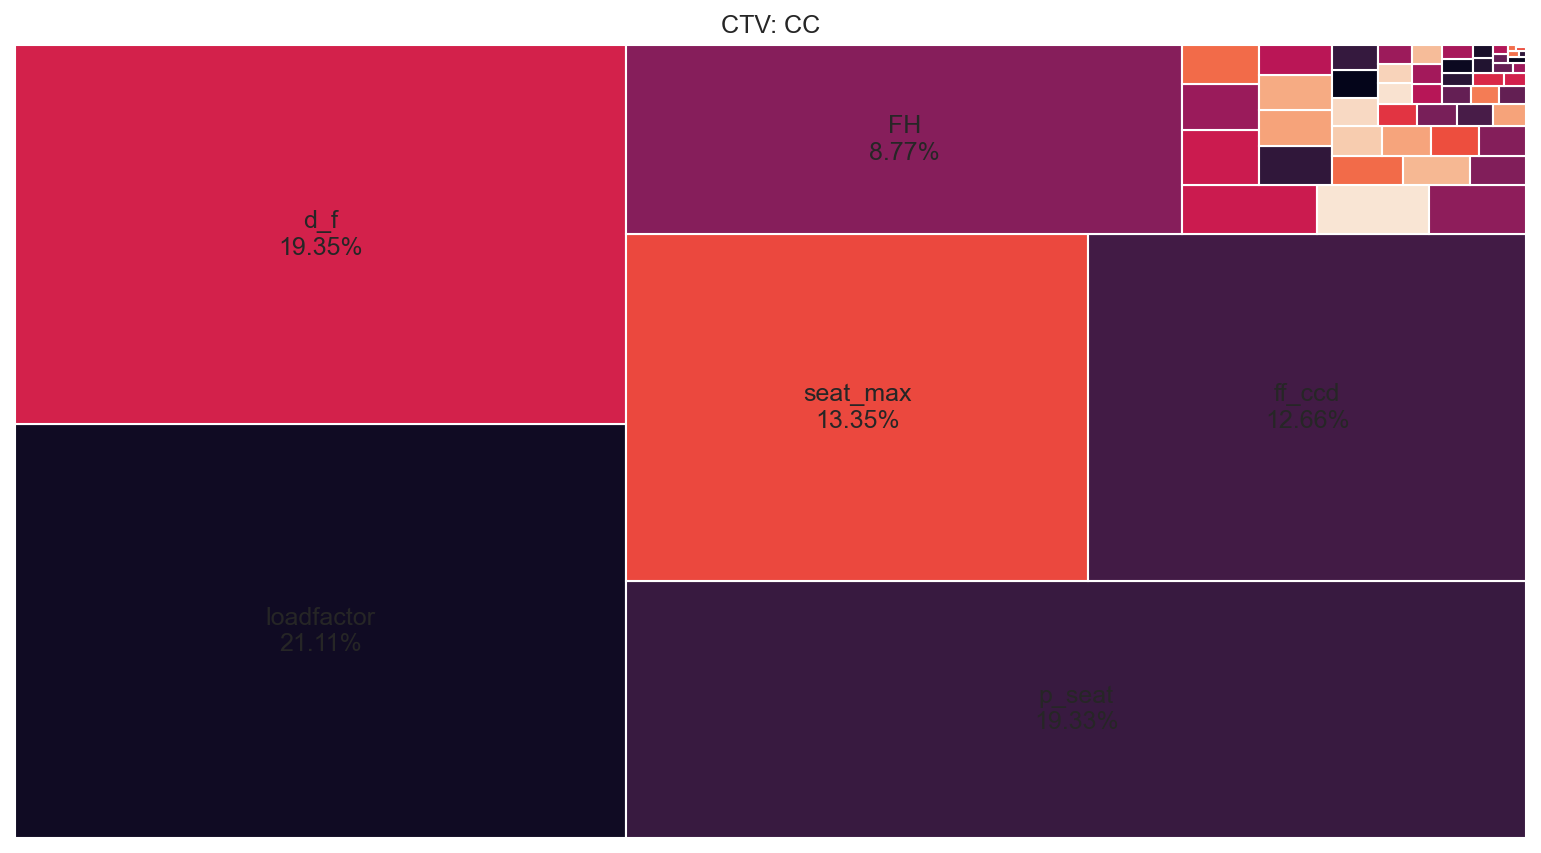

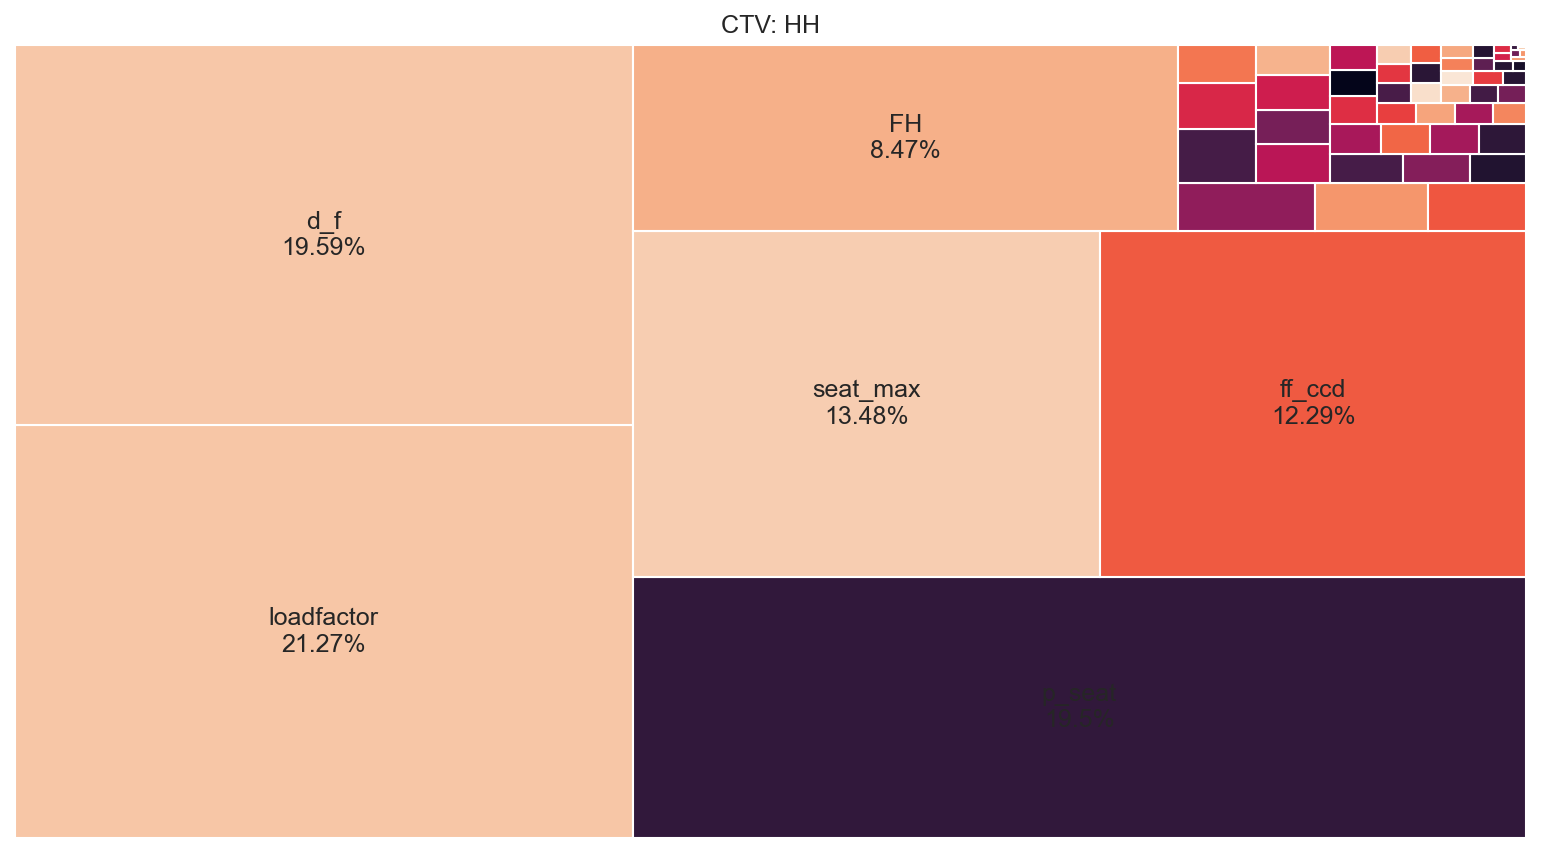

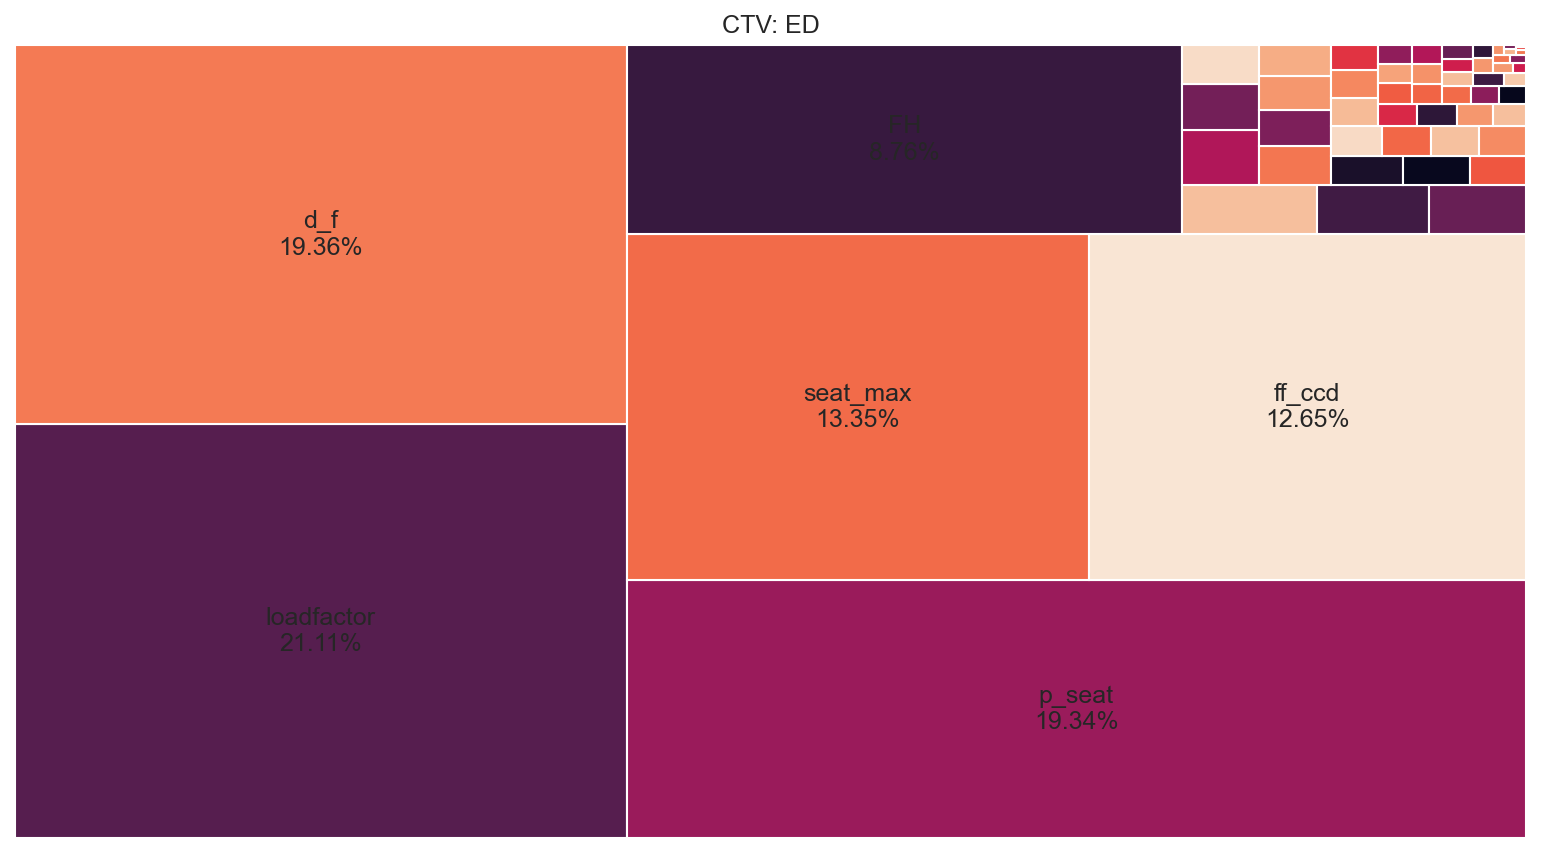

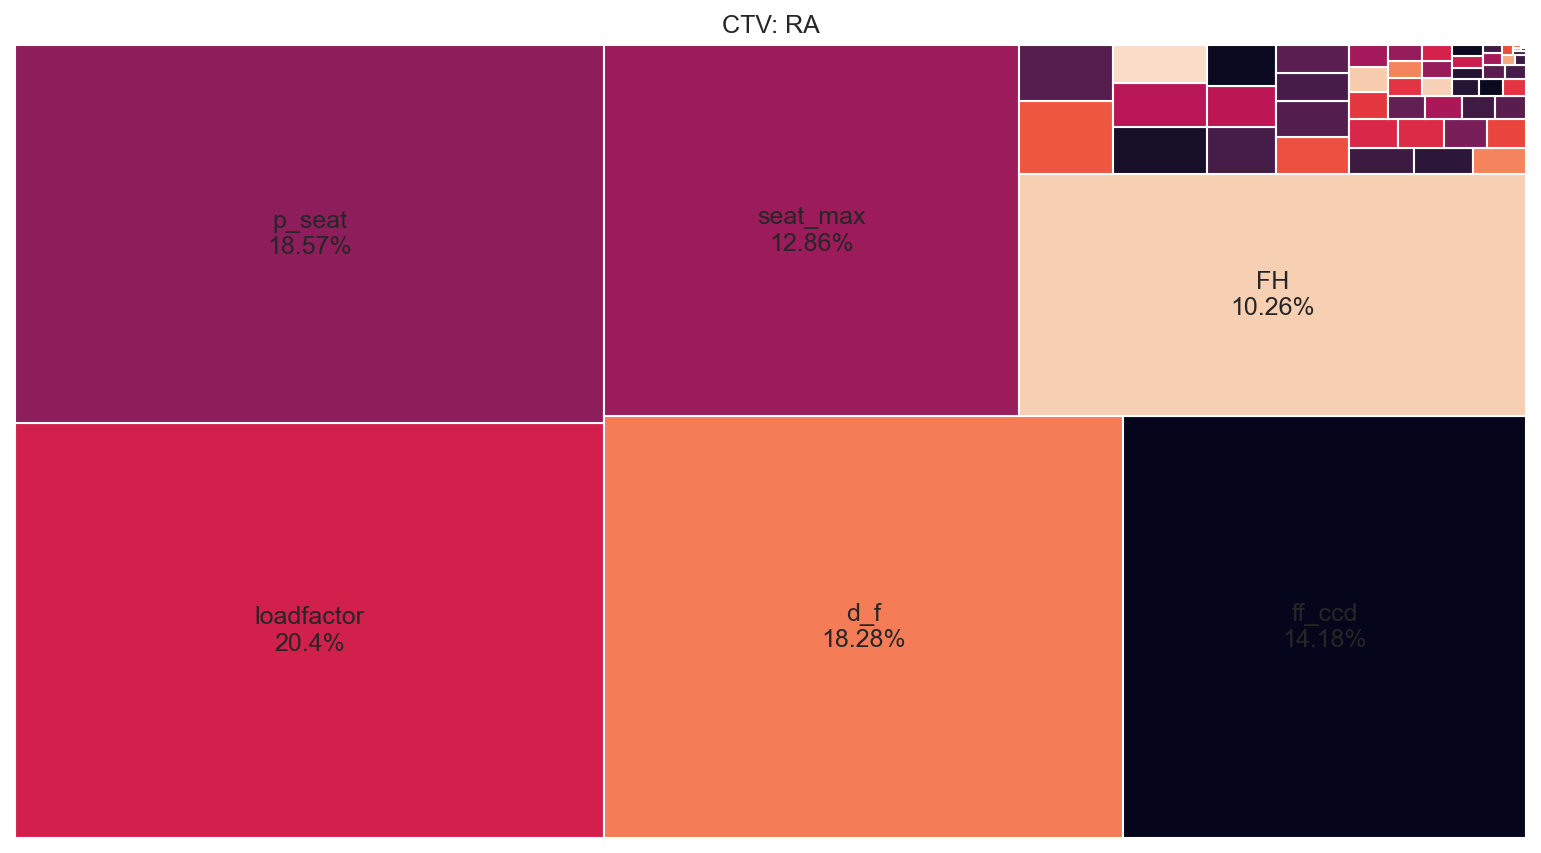

In [8]:
aeco.square(save=False)

# Comparison

In [7]:
bravo_path = './results/Bravo_results'
echo_path = './results/Echo_results'

In [ ]:
bravo = LCIA.load(bravo_path, chunks{}, CTV=False, LCI=False)
echo = LCIA.load(echo_path, chunks{}, CTV=False, LCI=False)

CÓDIGO USADO NO AECO ANTIGO

In [19]:
EP_RATIO = EP_A.sum(axis=1)/EP_B.sum(axis=1)

In [20]:
EP_RATIO.apply(np.median).sort_values(ascending = False)

Damage to Human Health             0.995963
Damage to Ecosystem Diversity      0.994076
Damage to Resource Availability    0.992356
dtype: float64

In [21]:
EP_RATIO.apply(lambda x: x < 1).apply(lambda x:np.sum(x)/len(x)*100)

Damage to Human Health             50.85
Damage to Ecosystem Diversity      51.10
Damage to Resource Availability    51.50
dtype: float64

In all categories, the median of the ratio is smaller than unity, meaning that **A has less significant environmental impacts than B in every endpoint category**.

The same can be observed in the figure below.

In [178]:
EP_DB = database_series(EP_RATIO)

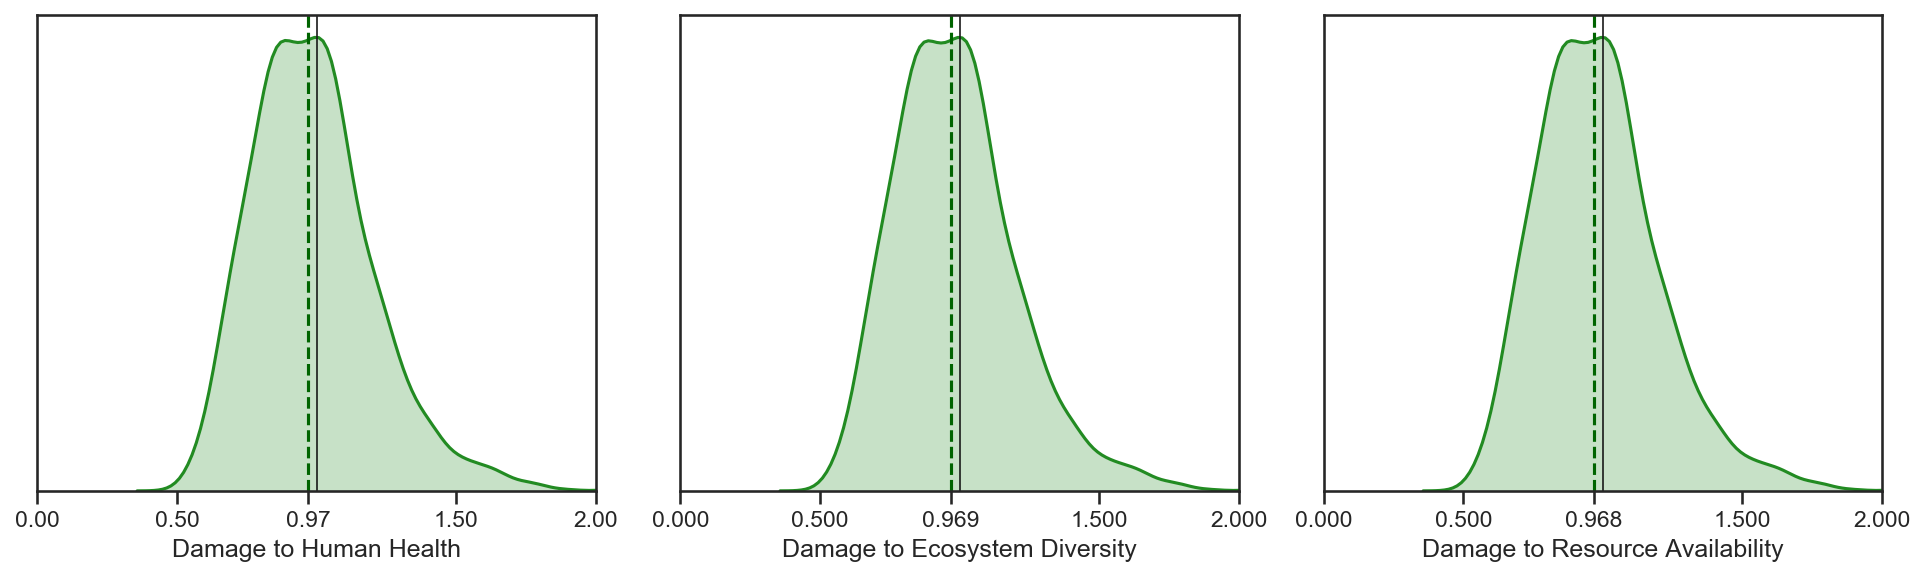

In [179]:
f, axes = plt.subplots(1, 3, figsize=(13, 4))
sns.set(style="ticks", palette="muted", color_codes=True)
axes = axes.ravel()

for column in EP_DB:
    i = EP_DB.columns.get_loc(column)
    sns.distplot(EP_DB[column], kde=True, hist=False, kde_kws={"shade": True}, \
                 ax=axes[i], color='forestgreen')
    axes[i].axvline(1, 0, 1, color='k', ls= '-', lw=0.8)
    axes[i].axvline(EP_DB[column].median(), 0, 1, color='darkgreen', ls= '--')
    axes[i].set_xticks([0, 0.5, EP_DB[column].median(), 1.5, 2])
    
plt.setp(axes, yticks=[],  xlim=[0,2])
plt.tight_layout()
f.set_dpi(150)
f.savefig('.\\results\\' + name_A + ' vs ' + name_B + ' endpoint.pdf', bbox_inches='tight', papertype='A4')
plt.show()